Target stations (H9 components): 18

--- Step 0: Downloading and Parsing GHCN Data ---
Extracting from: ./ghcnm.v4.0.1.20250415/ghcnm.tavg.v4.0.1.20250415.qcu.dat
Parsed 12156 valid monthly records for 18 target stations.

--- Step 1: Preparing Month x Year Matrices (Full Time Range) ---
Actual data range in raw data: 1893-2025
Found data for 18 stations in the raw data.
Created matrices for 18 stations.

--- Step 2: Plotting Individual Station Heatmaps by Pair ---
Global temperature range for color scale: -14.8°C to 32.6°C

Individual Station heatmaps by pair saved as ghcnv4m_INDIVIDUAL_H9comp_heatmaps_BY_PAIR_1893-2025.png

--- Plotting Individual Stations by Pair Complete ---


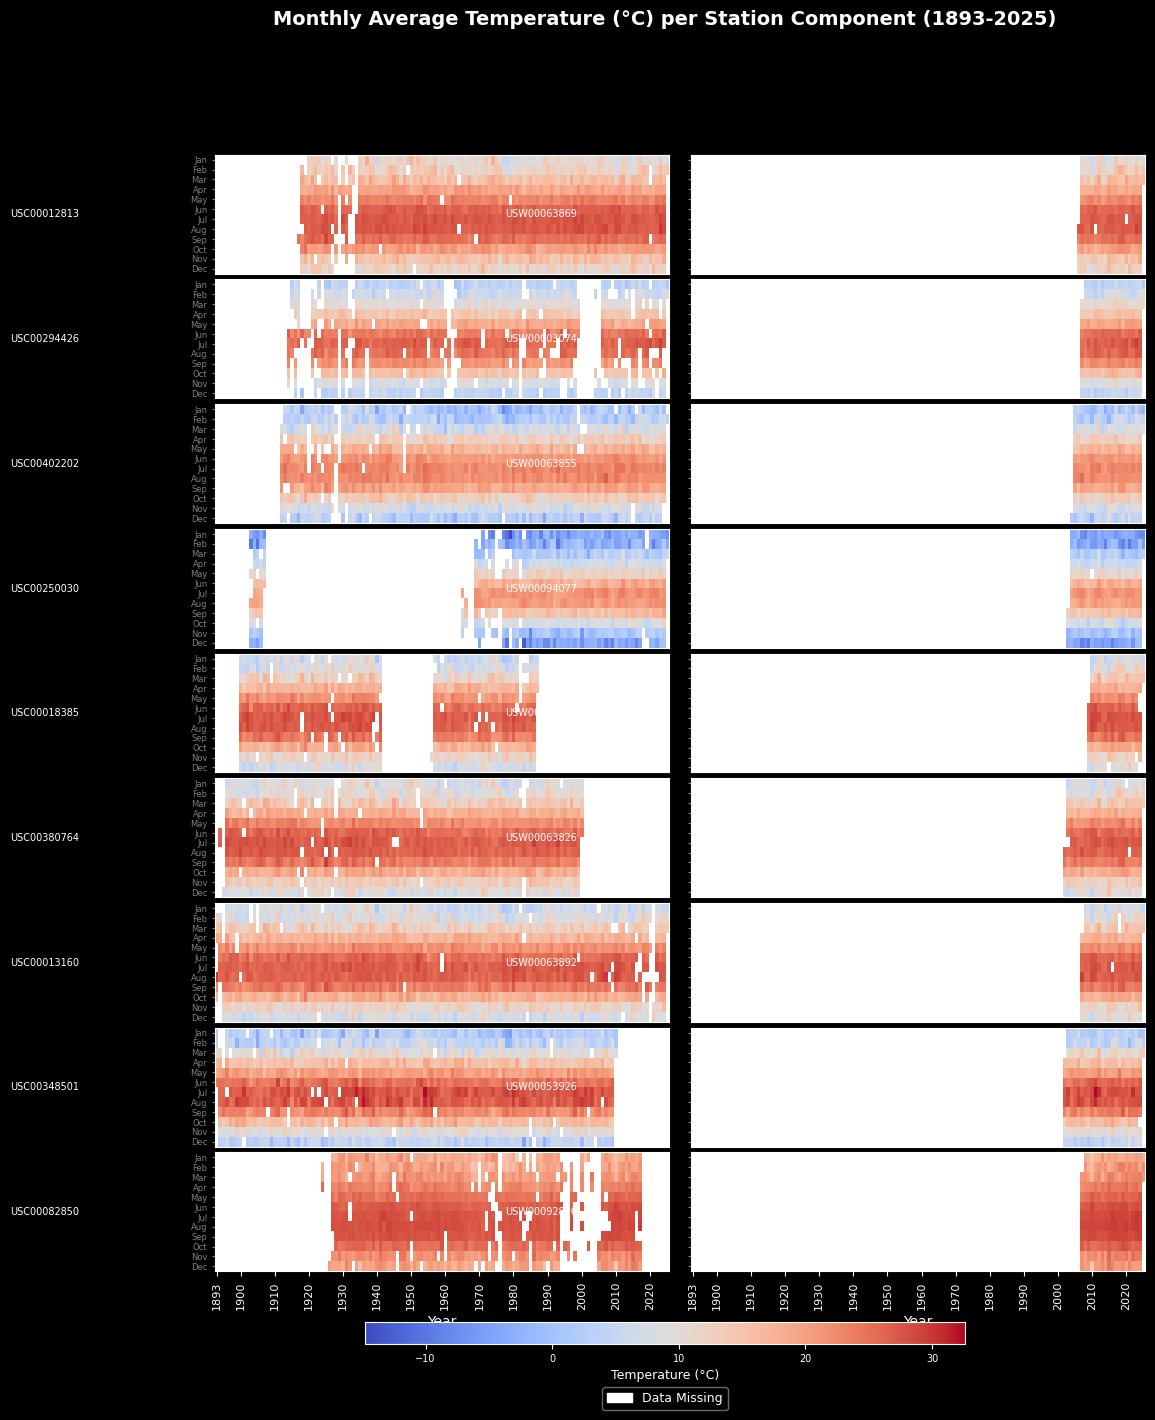

In [88]:
# FINAL PLOT v6: Plot 18 INDIVIDUAL Heatmaps, Arranged by Pair (Legacy | USCRN)

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches # For custom legend
import sys
import io
import requests
import tarfile

# Suppress specific warnings if needed (optional)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

# ==============================================================================
# Configuration
# ==============================================================================

# --- Time Period for Visualization ---
# Determined dynamically from data

# --- Station Pairs (Defines the layout and target stations) ---
STATION_PAIRS_H9 = [
    ("USC00012813", "USW00063869"), # Pair 0 (Row 0)
    ("USC00294426", "USW00003074"), # Pair 1 (Row 1)
    ("USC00402202", "USW00063855"), # Pair 2 (Row 2)
    ("USC00250030", "USW00094077"), # Pair 3 (Row 3)
    ("USC00018385", "USW00073801"), # Pair 4 (Row 4)
    ("USC00380764", "USW00063826"), # Pair 5 (Row 5)
    ("USC00013160", "USW00063892"), # Pair 6 (Row 6)
    ("USC00348501", "USW00053926"), # Pair 7 (Row 7)
    ("USC00082850", "USW00092826")  # Pair 8 (Row 8)
]
# Get the individual component IDs needed for fetching
component_station_ids = sorted(list({sid for pair in STATION_PAIRS_H9 for sid in pair}))
print(f"Target stations (H9 components): {len(component_station_ids)}")

# --- Colormap for Temperature ---
TEMP_COLORMAP = 'coolwarm'

# --- Data Source ---
GHCN_DATA_URL = "https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcu.tar.gz"

# ==============================================================================
# Step 0: Download and Parse GHCNv4 Data for Target Stations
# ==============================================================================
print("\n--- Step 0: Downloading and Parsing GHCN Data ---")
# ... (Same robust data loading as previous correct examples) ...
all_station_ids_needed = set(component_station_ids)
filtered_lines = []; dat_member_name = "Unknown"
try:
    response = requests.get(GHCN_DATA_URL, stream=True); response.raise_for_status(); tar_bytes = io.BytesIO(response.content)
    with tarfile.open(fileobj=tar_bytes, mode="r:gz") as tar:
        dat_members = [m for m in tar.getmembers() if m.name.endswith(".qcu.dat")]; dat_member = dat_members[0]; dat_member_name = dat_member.name
        print(f"Extracting from: {dat_member_name}"); dat_file = tar.extractfile(dat_member);
        for line_bytes in dat_file:
             try: line_str = line_bytes.decode("utf-8", errors='replace'); sid = line_str[0:11].strip();
             except Exception : continue
             if sid in all_station_ids_needed and line_str[15:19] == "TAVG": filtered_lines.append(line_str)
except Exception as e: print(f"Tar Error: {e}"); sys.exit()
monthly_records = [] # Parse
parse_errors = 0
for line in filtered_lines:
    sid = line[0:11].strip();
    try:
        year = int(line[11:15])
        for m in range(12):
            month = m + 1; start_idx = 19 + m*8; end_idx = start_idx + 5
            val_str = line[start_idx : end_idx].strip()
            if val_str and val_str != "-9999": monthly_records.append([year, month, sid, int(val_str) / 100.0])
    except Exception as e: parse_errors += 1
df_monthly_raw = pd.DataFrame(monthly_records, columns=["year", "month", "station_id", "tavg"])
print(f"Parsed {len(df_monthly_raw)} valid monthly records for {df_monthly_raw['station_id'].nunique()} target stations.")
if parse_errors > 0: print(f"Encountered {parse_errors} parsing errors.")
if df_monthly_raw.empty: print("ERROR: No monthly records parsed. Exiting."); sys.exit()

# ==============================================================================
# Step 1: Prepare Data Matrices (Month x Year) for Each INDIVIDUAL Station
# ==============================================================================
print("\n--- Step 1: Preparing Month x Year Matrices (Full Time Range) ---")

# *** NO TIME FILTERING here, use all parsed data ***
df_viz_data = df_monthly_raw

if df_viz_data.empty: print(f"ERROR: Raw data is empty."); sys.exit()

# Determine the actual min/max year present in the raw data for these stations
ACTUAL_START_YEAR = df_viz_data['year'].min()
ACTUAL_END_YEAR = df_viz_data['year'].max()
print(f"Actual data range in raw data: {ACTUAL_START_YEAR}-{ACTUAL_END_YEAR}")

all_years_in_data_range = list(range(ACTUAL_START_YEAR, ACTUAL_END_YEAR + 1))
all_months_in_range = list(range(1, 13))

station_matrices = {}
# Create matrices ONLY for the stations present in the H9 pairs list
stations_to_process = component_station_ids # Use the specific list of 18
actual_stations_found_in_data = sorted(list(df_viz_data['station_id'].unique()))
print(f"Found data for {len(actual_stations_found_in_data)} stations in the raw data.")

stations_with_matrices = []
for station_id in stations_to_process:
    if station_id not in actual_stations_found_in_data:
        print(f"  Skipping matrix creation for {station_id} (no data found).")
        continue # Skip stations for which no data was parsed

    df_station = df_viz_data[df_viz_data['station_id'] == station_id]
    pivot_table = df_station.pivot_table(index='month', columns='year', values='tavg', aggfunc='mean')
    matrix = pivot_table.reindex(index=all_months_in_range, columns=all_years_in_data_range) # Fills missing with NaN
    station_matrices[station_id] = matrix
    stations_with_matrices.append(station_id)
    # print(f"  Created matrix for {station_id}, shape: {matrix.shape}") # Optional debug

if not station_matrices: print("ERROR: Failed to create matrices for any target station."); sys.exit()
print(f"Created matrices for {len(stations_with_matrices)} stations.")

# ==============================================================================
# Step 2: Plotting the INDIVIDUAL Station Heatmaps, Arranged by Pair
# ==============================================================================
print("\n--- Step 2: Plotting Individual Station Heatmaps by Pair ---")

n_pairs = len(STATION_PAIRS_H9)
n_rows = n_pairs # 9 rows
n_cols = 2      # 2 columns (Legacy, USCRN)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 1.5 * n_rows + 1),
                         sharex=True, sharey=True, squeeze=False, # Share both axes
                         gridspec_kw = {'wspace':0.05, 'hspace':0.05}) # Reduce spacing
# axes is a 2D array [row, col]

plt.style.use('dark_background')
fig.suptitle(f"Monthly Average Temperature (°C) per Station Component ({ACTUAL_START_YEAR}-{ACTUAL_END_YEAR})", fontsize=14, weight='bold', color='white')

# Determine overall temperature range
all_temps = pd.concat([df.stack() for df in station_matrices.values()]).dropna()
vmin = all_temps.min() if not all_temps.empty else -15
vmax = all_temps.max() if not all_temps.empty else 35
print(f"Global temperature range for color scale: {vmin:.1f}°C to {vmax:.1f}°C")

cmap = plt.get_cmap(TEMP_COLORMAP).copy(); cmap.set_bad(color='white'); norm = Normalize(vmin=vmin, vmax=vmax)

# Iterate through the PAIRS to determine plot placement
for row_idx, pair in enumerate(STATION_PAIRS_H9):
    legacy_id, uscrn_id = pair

    # --- Plot Legacy Station (Left Column) ---
    ax_left = axes[row_idx, 0]
    if legacy_id in station_matrices:
        matrix_df = station_matrices[legacy_id]; data_array = matrix_df.values
        num_years_in_matrix = data_array.shape[1]
        extent = [ACTUAL_START_YEAR - 0.5, ACTUAL_END_YEAR + 0.5, 12.5, 0.5]
        im = ax_left.imshow(data_array, cmap=cmap, norm=norm, aspect='auto', interpolation='nearest', extent=extent)
        ax_left.set_yticks(np.arange(1, 13)); ax_left.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], fontsize=6, color='gray')
        ax_left.set_ylabel(legacy_id, fontsize=7, color='white', rotation=0, labelpad=80, va='center', ha='right') # Adjust labelpad maybe
    else:
        ax_left.set_facecolor('#111111') # Dark background for missing plot
        ax_left.text(0.5, 0.5, f"{legacy_id}\n(No Data)", color="gray", ha='center', va='center', transform=ax_left.transAxes, fontsize=8)
        ax_left.set_yticks([]); ax_left.set_xticks([]) # Hide axes if no data

    # --- Plot USCRN Station (Right Column) ---
    ax_right = axes[row_idx, 1]
    if uscrn_id in station_matrices:
        matrix_df = station_matrices[uscrn_id]; data_array = matrix_df.values
        num_years_in_matrix = data_array.shape[1]
        extent = [ACTUAL_START_YEAR - 0.5, ACTUAL_END_YEAR + 0.5, 12.5, 0.5]
        im = ax_right.imshow(data_array, cmap=cmap, norm=norm, aspect='auto', interpolation='nearest', extent=extent)
        # Y labels only needed if left plot was empty (handled by sharey=True)
        # ax_right.set_yticks(np.arange(1, 13)); ax_right.set_yticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'], fontsize=6, color='gray')
        ax_right.set_ylabel(uscrn_id, fontsize=7, color='white', rotation=0, labelpad=80, va='center', ha='right')
    else:
        ax_right.set_facecolor('#111111')
        ax_right.text(0.5, 0.5, f"{uscrn_id}\n(No Data)", color="gray", ha='center', va='center', transform=ax_right.transAxes, fontsize=8)
        ax_right.set_yticks([]); ax_right.set_xticks([])

    # --- Common Row Formatting ---
    # X-axis: Year labels (only on bottom row)
    if row_idx == n_rows - 1: # If in the last row
        for ax in [ax_left, ax_right]:
             if ax.has_data(): # Only add ticks if plot has data
                start_tick_year = ACTUAL_START_YEAR + (10 - ACTUAL_START_YEAR % 10)
                if start_tick_year > ACTUAL_END_YEAR: start_tick_year = ACTUAL_START_YEAR
                tick_years = np.arange(start_tick_year, ACTUAL_END_YEAR + 1, 10)
                if ACTUAL_START_YEAR < tick_years[0] - 5 : tick_years = np.insert(tick_years, 0, ACTUAL_START_YEAR)
                if ACTUAL_END_YEAR > tick_years[-1] + 5 : tick_years = np.append(tick_years, ACTUAL_END_YEAR)

                ax.set_xticks(tick_years); ax.set_xticklabels(tick_years, rotation=90); ax.tick_params(axis='x', colors='white', labelsize=8)
                ax.set_xlabel("Year", fontsize=10, color='white')
    else:
        # Hide X ticks and labels for upper rows
        for ax in [ax_left, ax_right]:
            ax.tick_params(axis='x', bottom=False, labelbottom=False)

    # Set x-limits for all plots in the row
    for ax in [ax_left, ax_right]:
         if ax.has_data(): ax.set_xlim(extent[0], extent[1])
         ax.tick_params(axis='y', length=2, colors='gray') # Y ticks appearance


# Add color bar and legend
cbar_ax = fig.add_axes([0.25, 0.06, 0.5, 0.015]); sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal'); cbar.set_label('Temperature (°C)', color='white', size=9); cbar.ax.tick_params(colors='white', labelsize=7)
white_patch = mpatches.Patch(color='white', label='Data Missing'); fig.legend(handles=[white_patch], loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=1, fontsize=9, facecolor='black', edgecolor='gray')

# Use tight_layout first, then adjust manually if needed
fig.tight_layout(rect=[0.10, 0.08, 0.98, 0.95]) # Adjust left margin for station IDs


# --- Save Plot ---
try:
    output_filename = f"ghcnv4m_INDIVIDUAL_H9comp_heatmaps_BY_PAIR_{ACTUAL_START_YEAR}-{ACTUAL_END_YEAR}.png"
    plt.savefig(output_filename, dpi=150, bbox_inches='tight', facecolor='black')
    print(f"\nIndividual Station heatmaps by pair saved as {output_filename}")
except Exception as e: print(f"\nError saving plot: {e}")

print("\n--- Plotting Individual Stations by Pair Complete ---")

Component stations needed for H9 pairs: 18

--- Step 0: Downloading and Parsing GHCN Data ---
Extracting ./ghcnm.v4.0.1.20250415/ghcnm.tavg.v4.0.1.20250415.qcu.dat
Parsed 24312 TAVG records for 18 component stations.

--- Step 1: Stitching Pairs ---
Completed stitching. 9 pairs have some data.

--- Step 2: Preparing Month x Year Matrices (Full Time Range) ---
Actual data range considered for matrix: 1893-2025
Creating/Reindexing matrices for ALL 9 defined pairs:

--- Step 3: Plotting 9 Stitched Pair Heatmaps (Single Column Layout) ---
Color scale range: -14.8°C to 32.6°C
Plotting Axis 0: COMP_USC00012813_USW00063869
  Plotting heatmap for COMP_USC00012813_USW00063869
Plotting Axis 1: COMP_USC00294426_USW00003074
  Plotting heatmap for COMP_USC00294426_USW00003074
Plotting Axis 2: COMP_USC00402202_USW00063855
  Plotting heatmap for COMP_USC00402202_USW00063855
Plotting Axis 3: COMP_USC00250030_USW00094077
  Plotting heatmap for COMP_USC00250030_USW00094077
Plotting Axis 4: COMP_USC00018

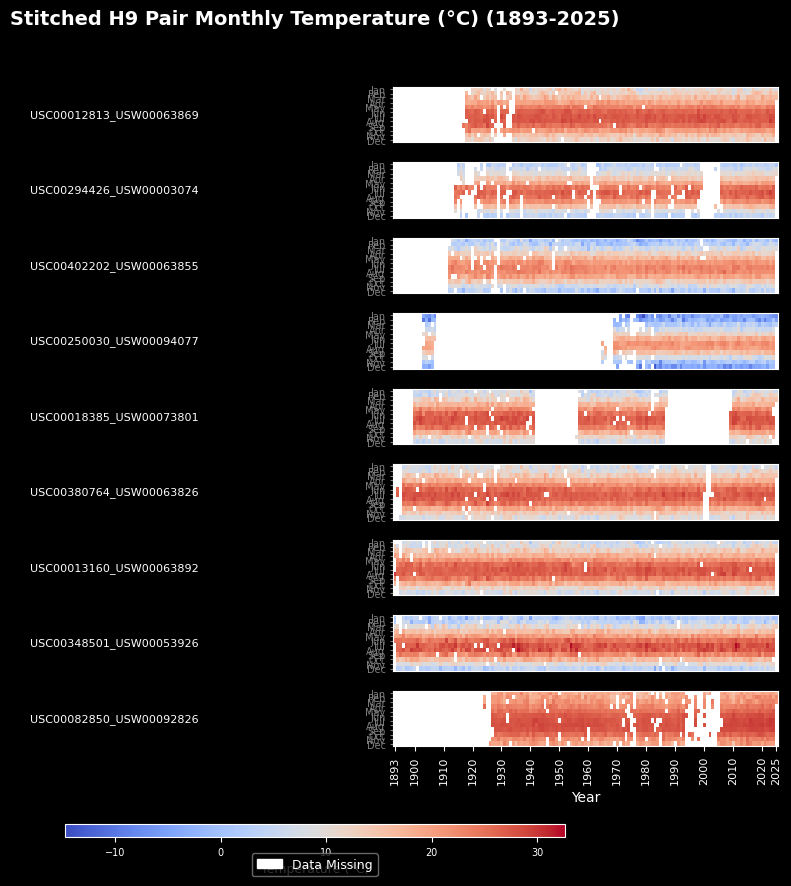

In [89]:
# FINAL PLOT v12: Plot 9 Stitched Pair Heatmaps (Month vs Year) in 9 ROWS

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches # For custom legend
import sys
import io
import requests
import tarfile

# Suppress specific warnings if needed (optional)
warnings.filterwarnings("ignore") # Suppress all warnings for simplicity

# ==============================================================================
# Configuration
# ==============================================================================
TEMP_COLORMAP = 'coolwarm'
STATION_PAIRS_H9 = [
    ("USC00012813", "USW00063869"), ("USC00294426", "USW00003074"),
    ("USC00402202", "USW00063855"), ("USC00250030", "USW00094077"),
    ("USC00018385", "USW00073801"), ("USC00380764", "USW00063826"),
    ("USC00013160", "USW00063892"), ("USC00348501", "USW00053926"),
    ("USC00082850", "USW00092826")
]
component_station_ids = sorted(list({sid for pair in STATION_PAIRS_H9 for sid in pair}))
print(f"Component stations needed for H9 pairs: {len(component_station_ids)}")
GHCN_DATA_URL = "https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcu.tar.gz"
# ==============================================================================

# ==============================================================================
# Step 0: Download and Parse GHCNv4 Data for Component Stations
# ==============================================================================
print("\n--- Step 0: Downloading and Parsing GHCN Data ---")
# ... (Assume same robust data loading - Skipped for brevity, use previous code) ...
all_station_ids_needed = set(component_station_ids)
filtered_lines = []; dat_member_name = "Unknown"
try:
    response = requests.get(GHCN_DATA_URL, stream=True); response.raise_for_status(); tar_bytes = io.BytesIO(response.content)
    with tarfile.open(fileobj=tar_bytes, mode="r:gz") as tar:
        dat_member = [m for m in tar.getmembers() if m.name.endswith(".qcu.dat")][0]; print(f"Extracting {dat_member.name}")
        with tar.extractfile(dat_member) as dat_file:
            for line_bytes in dat_file:
                try:
                    line_str = line_bytes.decode("utf-8"); sid = line_str[0:11]
                    if sid in all_station_ids_needed and line_str[15:19] == "TAVG":
                        year = int(line_str[11:15])
                        for m in range(12):
                            val_str = line_str[19 + m*8 : 24 + m*8].strip()
                            if val_str and val_str != "-9999": monthly_records.append([year, m + 1, sid, int(val_str) / 100.0])
                except Exception: continue
except Exception as e: print(f"Tar Error: {e}"); sys.exit()
df_monthly_raw = pd.DataFrame(monthly_records, columns=["year", "month", "station_id", "tavg"])
print(f"Parsed {len(df_monthly_raw)} TAVG records for {df_monthly_raw['station_id'].nunique()} component stations.")
if df_monthly_raw.empty: print("FATAL ERROR: No records parsed."); sys.exit()
# ==============================================================================

# ==============================================================================
# Step 1: Stitch Station Pairs (Simple Merge/Select)
# ==============================================================================
print("\n--- Step 1: Stitching Pairs ---")
# ... (Assume same robust stitching logic - Skipped for brevity, use previous code) ...
processed_stitched_data = []; defined_composite_ids = []
for pair in STATION_PAIRS_H9:
    legacy_id, uscrn_id = pair; pair_id_str = f"COMP_{legacy_id}_{uscrn_id}"; defined_composite_ids.append(pair_id_str)
    df_legacy = df_monthly_raw[df_monthly_raw['station_id'] == legacy_id][['year', 'month', 'tavg']].copy()
    df_uscrn = df_monthly_raw[df_monthly_raw['station_id'] == uscrn_id][['year', 'month', 'tavg']].copy()
    if not df_legacy.set_index(['year', 'month']).index.is_unique: df_legacy = df_legacy.groupby(['year', 'month'], as_index=False)['tavg'].mean()
    if not df_uscrn.set_index(['year', 'month']).index.is_unique: df_uscrn = df_uscrn.groupby(['year', 'month'], as_index=False)['tavg'].mean()
    merged = pd.merge(df_legacy, df_uscrn, on=['year', 'month'], how='outer', suffixes=('_legacy', '_uscrn'))
    merged['tavg'] = np.where(merged['tavg_uscrn'].notna() & merged['tavg_legacy'].notna(), (merged['tavg_legacy'] + merged['tavg_uscrn']) / 2.0, merged['tavg_uscrn'].combine_first(merged['tavg_legacy']))
    stitched_result = merged[['year', 'month', 'tavg']].copy(); stitched_result.dropna(subset=['tavg'], inplace=True)
    if not stitched_result.empty: stitched_result['station_id'] = pair_id_str; processed_stitched_data.append(stitched_result)
    else: processed_stitched_data.append(pd.DataFrame({'year': [], 'month': [], 'station_id': [pair_id_str], 'tavg': []})) # Add placeholder
df_stitched_pairs = pd.concat(processed_stitched_data, ignore_index=True)
stitched_ids_with_data = df_stitched_pairs['station_id'][df_stitched_pairs['tavg'].notna()].unique() # Check which ones ended up with data
print(f"Completed stitching. {len(stitched_ids_with_data)} pairs have some data.")
# ==============================================================================

# ==============================================================================
# Step 2: Prepare Month x Year Matrices for Stitched Pairs
# ==============================================================================
print("\n--- Step 2: Preparing Month x Year Matrices (Full Time Range) ---")
df_viz_data = df_stitched_pairs
if df_viz_data.empty: print("Warning: Stitched data is empty, matrices will be empty.");
ACTUAL_START_YEAR = int(df_viz_data['year'].min()) if not df_viz_data.empty else 1900
ACTUAL_END_YEAR = int(df_viz_data['year'].max()) if not df_viz_data.empty else 2024
print(f"Actual data range considered for matrix: {ACTUAL_START_YEAR}-{ACTUAL_END_YEAR}")
all_years_in_data_range = list(range(ACTUAL_START_YEAR, ACTUAL_END_YEAR + 1)); all_months_in_range = list(range(1, 13))

station_matrices = {}
print("Creating/Reindexing matrices for ALL 9 defined pairs:")
for station_id in defined_composite_ids: # Iterate through the 9 defined names
    df_station = df_viz_data[df_viz_data['station_id'] == station_id]
    if not df_station.empty and df_station['tavg'].notna().any(): # Check if there's any actual data
        # print(f"  Processing matrix for {station_id}...") # Debug
        if not df_station.set_index(['year', 'month']).index.is_unique: df_station = df_station.groupby(['year', 'month'], as_index=False)['tavg'].mean()
        pivot_table = df_station.pivot_table(index='month', columns='year', values='tavg')
        matrix = pivot_table.reindex(index=all_months_in_range, columns=all_years_in_data_range)
        station_matrices[station_id] = matrix
    else:
        print(f"  No data for {station_id}, creating empty matrix.") # Debug
        station_matrices[station_id] = pd.DataFrame(np.nan, index=all_months_in_range, columns=all_years_in_data_range)

if len(station_matrices) != 9: print(f"!!! CRITICAL ERROR: Created {len(station_matrices)} matrices, expected 9 !!!")
# ==============================================================================

# ==============================================================================
# Step 3: Plotting the 9 Stitched Pair Heatmaps using imshow (9 Rows x 1 Column)
# ==============================================================================
print("\n--- Step 3: Plotting 9 Stitched Pair Heatmaps (Single Column Layout) ---")

n_pairs = 9 # We explicitly want 9 plots
# *** Set layout to 9 rows, 1 column ***
n_cols = 1
n_rows = n_pairs
# *** Adjust figsize for tall/narrow layout ***
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 1 * n_rows), # Wider figure, adjust height per row
                         sharex=True, squeeze=False) # squeeze=False important for single column
axes = axes.flatten() # Flatten for easy 1D indexing (0 to 8)

plt.style.use('dark_background')
fig.suptitle(f"Stitched H9 Pair Monthly Temperature (°C) ({ACTUAL_START_YEAR}-{ACTUAL_END_YEAR})", fontsize=14, weight='bold', color='white')

# Determine overall temperature range
all_temps_list = [df.stack() for df in station_matrices.values() if not df.empty and not df.isnull().all().all()]
vmin, vmax = -15, 15
if all_temps_list:
    all_temps = pd.concat(all_temps_list).dropna()
    if not all_temps.empty: vmin = all_temps.min(); vmax = all_temps.max()
print(f"Color scale range: {vmin:.1f}°C to {vmax:.1f}°C")

cmap = plt.get_cmap(TEMP_COLORMAP).copy(); cmap.set_bad(color='white'); norm = Normalize(vmin=vmin, vmax=vmax)

station_ids_to_plot = defined_composite_ids # Use the defined list of 9 IDs

for i, station_id in enumerate(station_ids_to_plot):
    ax = axes[i]; matrix_df = station_matrices.get(station_id)
    print(f"Plotting Axis {i}: {station_id}") # Debug

    if matrix_df is None:
         ax.set_facecolor('#111111'); ax.text(0.5, 0.5, "Matrix Error", color="red", ha='center', va='center', transform=ax.transAxes, fontsize=8); ax.set_yticks([]); ax.set_xticks([]); continue

    data_array = matrix_df.values
    if np.all(np.isnan(data_array)):
        print(f"  Matrix for {station_id} is empty/NaN. Displaying 'No Data'.")
        ax.set_facecolor('#111111'); ax.text(0.5, 0.5, f"{station_id.replace('COMP_','')}\n(No Data)", color="gray", ha='center', va='center', transform=ax.transAxes, fontsize=8); ax.set_yticks([]); ax.set_xticks([])
    else:
        print(f"  Plotting heatmap for {station_id}")
        extent = [ACTUAL_START_YEAR - 0.5, ACTUAL_END_YEAR + 0.5, 12.5, 0.5]
        im = ax.imshow(data_array, cmap=cmap, norm=norm, aspect='auto', interpolation='nearest', extent=extent)
        ax.set_yticks(np.arange(1, 13)); ax.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], fontsize=7, color='gray') # Slightly larger font
        ax.tick_params(axis='y', length=2, colors='gray')
        ax.set_xlim(extent[0], extent[1])

        # *** Add Y Label (Pair ID) to EVERY plot ***
        ax.set_ylabel(station_id.replace("COMP_",""), fontsize=8, color='white', rotation=0, labelpad=120, va='center', ha='right') # Increased padding more

    # --- X-axis Ticks and Labels (only on bottom plot) ---
    if i == n_rows - 1: # If it's the last row (index 8 for 9 rows)
        # Apply ticks/labels only if the axis wasn't turned off
        if not np.all(np.isnan(data_array)):
            start_tick_year = ACTUAL_START_YEAR + (10 - ACTUAL_START_YEAR % 10);
            if start_tick_year > ACTUAL_END_YEAR: start_tick_year = ACTUAL_START_YEAR
            tick_years = np.arange(start_tick_year, ACTUAL_END_YEAR + 1, 10)
            if ACTUAL_START_YEAR < tick_years[0] - 5 : tick_years = np.insert(tick_years, 0, ACTUAL_START_YEAR)
            tick_years = np.unique(np.append(tick_years, ACTUAL_END_YEAR))
            tick_years = tick_years[(tick_years >= ACTUAL_START_YEAR) & (tick_years <= ACTUAL_END_YEAR)]
            ax.set_xticks(tick_years); ax.set_xticklabels(tick_years, rotation=90); ax.tick_params(axis='x', colors='white', labelsize=8)
            ax.set_xlabel("Year", fontsize=10, color='white')
    else:
        ax.tick_params(axis='x', bottom=False, labelbottom=False)

# --- Hide unused axes (Not needed when n_rows = n_stations) ---

# Add color bar and legend
cbar_ax = fig.add_axes([0.25, 0.06, 0.5, 0.015]); sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal'); cbar.set_label('Temperature (°C)', color='white', size=9); cbar.ax.tick_params(colors='white', labelsize=7)
white_patch = mpatches.Patch(color='white', label='Data Missing'); fig.legend(handles=[white_patch], loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=1, fontsize=9, facecolor='black', edgecolor='gray')

# *** Adjust layout for single column, more left padding ***
fig.tight_layout(rect=[0.20, 0.08, 0.98, 0.95]) # Increased left margin significantly

# --- Save Plot ---
try:
    output_filename = f"ghcnv4m_stitched_h9_heatmaps_9ROWS_{ACTUAL_START_YEAR}-{ACTUAL_END_YEAR}.png"
    plt.savefig(output_filename, dpi=150, bbox_inches='tight', facecolor='black')
    print(f"\nStitched pair heatmap plot (9 rows) saved as {output_filename}")
except Exception as e: print(f"\nError saving plot: {e}")

print("\n--- Plotting 9 Stitched Pairs (Single Column) Complete ---")

Target stations (Gribble List): 27

--- Step 0: Downloading and Parsing GHCN Data ---
Extracting ./ghcnm.v4.0.1.20250415/ghcnm.tavg.v4.0.1.20250415.qcu.dat
Parsing data...
Parsed 32446 TAVG records for 26 target stations.

--- Step 1: Preparing Stacked Month vs Year Matrix ---
Actual data range in Gribble data: 1839-2025
Pivoting data (Station-Month vs Year)...
MultiIndex pivot table created with shape: (312, 187)
Final stacked matrix shape after reindex: (324, 187)

--- Step 2: Plotting Stacked Month vs Year Heatmap ---
Temperature range for color scale: -52.9°C to 54.5°C
Plotting data array of shape: (324, 187)

Stacked heatmap plot saved as ghcnv4m_Gribble_StackedHeatmap_1839-2025.png

--- Plotting Stacked Gribble Stations Complete ---


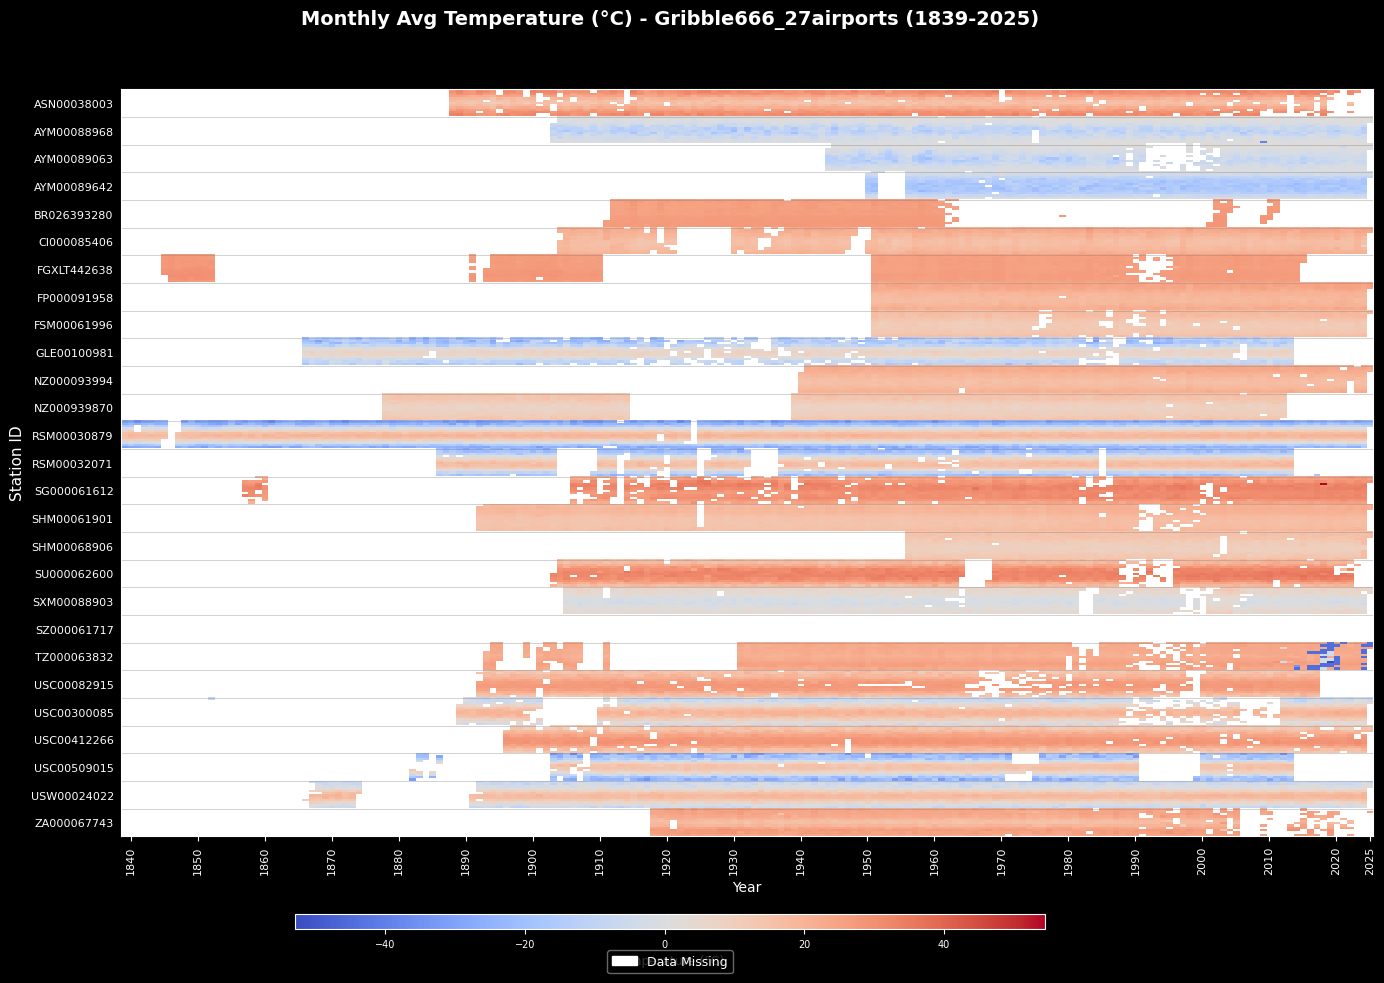

In [90]:
# FINAL PLOT v15: Plot Gribble Stations Heatmap (Stacked Month vs Year per Station)

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import sys
import io
import requests
import tarfile

warnings.filterwarnings("ignore") # Suppress all warnings

# ==============================================================================
# Configuration
# ==============================================================================
# --- Stations to Plot (Group B - Gribble666_27airports) ---
STATION_IDS_GRIBBLE = sorted(list({ # Ensure sorted list
    "USC00412266", "SG000061612", "FP000091958", "SU000062600", "CI000085406",
    "FSM00061996", "ASN00038003", "AYM00088968", "FGXLT442638", "USW00024022",
    "RSM00032071", "SHM00068906", "TZ000063832", "USC00082915", "AYM00089063",
    "NZ000939870", "SHM00061901", "GLE00100981", "ZA000067743", "SXM00088903",
    "SZ000061717", "USC00509015", "AYM00089642", "RSM00030879", "USC00300085",
    "BR026393280", "NZ000093994"
}))
print(f"Target stations (Gribble List): {len(STATION_IDS_GRIBBLE)}")
gribble_series_name = "Gribble666_27airports"
# --- Colormap for Temperature ---
TEMP_COLORMAP = 'coolwarm'
# --- Data Source ---
GHCN_DATA_URL = "https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcu.tar.gz"
# ==============================================================================

# ==============================================================================
# Step 0: Download and Parse Data
# ==============================================================================
print("\n--- Step 0: Downloading and Parsing GHCN Data ---")
all_station_ids_needed = set(STATION_IDS_GRIBBLE)
# ... (Standard robust data loading - Skipped for brevity, use previous code) ...
filtered_lines = []; dat_member_name = "Unknown"
try:
    response = requests.get(GHCN_DATA_URL, stream=True); response.raise_for_status(); tar_bytes = io.BytesIO(response.content)
    with tarfile.open(fileobj=tar_bytes, mode="r:gz") as tar:
        dat_member = [m for m in tar.getmembers() if m.name.endswith(".qcu.dat")][0]; print(f"Extracting {dat_member.name}")
        with tar.extractfile(dat_member) as dat_file:
            for line_bytes in dat_file:
                try: line_str = line_bytes.decode("utf-8"); sid = line_str[0:11]
                except Exception : continue
                if sid in all_station_ids_needed and line_str[15:19] == "TAVG": filtered_lines.append(line_str)
except Exception as e: print(f"Tar Error: {e}"); sys.exit()
monthly_records = []; parse_errors = 0; print("Parsing data...")
for line in filtered_lines:
    sid = line[0:11].strip();
    try:
        year = int(line[11:15])
        for m in range(12):
            month = m + 1; start_idx = 19 + m*8; end_idx = start_idx + 5; val_str = line[start_idx : end_idx].strip()
            if val_str and val_str != "-9999": monthly_records.append([year, month, sid, int(val_str) / 100.0])
    except Exception as e: parse_errors += 1
df_monthly_raw = pd.DataFrame(monthly_records, columns=["year", "month", "station_id", "tavg"])
print(f"Parsed {len(df_monthly_raw)} TAVG records for {df_monthly_raw['station_id'].nunique()} target stations.")
if parse_errors > 0: print(f"Encountered {parse_errors} parsing errors.")
if df_monthly_raw.empty: print("FATAL ERROR: No records parsed."); sys.exit()
# ==============================================================================

# ==============================================================================
# Step 1: Prepare Stacked Month vs Year Matrix for Gribble Stations
# ==============================================================================
print("\n--- Step 1: Preparing Stacked Month vs Year Matrix ---")
df_viz_data = df_monthly_raw[df_monthly_raw['station_id'].isin(STATION_IDS_GRIBBLE)].copy()
if df_viz_data.empty: print("ERROR: No data found for Gribble stations."); sys.exit()

# Determine actual data range
ACTUAL_START_YEAR = int(df_viz_data['year'].min()); ACTUAL_END_YEAR = int(df_viz_data['year'].max())
print(f"Actual data range in Gribble data: {ACTUAL_START_YEAR}-{ACTUAL_END_YEAR}")
all_years_in_data_range = list(range(ACTUAL_START_YEAR, ACTUAL_END_YEAR + 1))

# Pivot to create Station x Month x Year structure first
try:
    print("Pivoting data (Station-Month vs Year)...")
    # Ensure unique station-year-month points before pivoting
    if df_viz_data.duplicated(subset=['station_id', 'year', 'month']).any():
        print("  Warning: Duplicate station-year-month entries found. Aggregating with mean.")
        df_viz_data = df_viz_data.groupby(['station_id', 'year', 'month'], as_index=False)['tavg'].mean()

    pivot_multi = df_viz_data.pivot_table(index=['station_id', 'month'], columns='year', values='tavg')
    print(f"MultiIndex pivot table created with shape: {pivot_multi.shape}")

    # Reindex to ensure all stations, all 12 months, and all years are present
    # Create the full MultiIndex we expect
    all_months_in_range = list(range(1, 13))
    # Use the defined STATION_IDS_GRIBBLE (sorted) for consistent row order
    station_order = STATION_IDS_GRIBBLE
    multi_index = pd.MultiIndex.from_product([station_order, all_months_in_range], names=['station_id', 'month'])

    matrix_temp_stacked = pivot_multi.reindex(index=multi_index, columns=all_years_in_data_range) # Fill missing with NaN
    print(f"Final stacked matrix shape after reindex: {matrix_temp_stacked.shape}") # Should have stations*12 rows

except Exception as e:
    print(f"Error creating pivot table: {e}"); sys.exit()


# ==============================================================================
# Step 2: Plotting the Stacked Heatmap using imshow
# ==============================================================================
print("\n--- Step 2: Plotting Stacked Month vs Year Heatmap ---")

if matrix_temp_stacked.empty: print("ERROR: No matrix data available to plot."); sys.exit()

n_stations = len(station_order)
n_total_rows = matrix_temp_stacked.shape[0] # Total Y-axis dimension (stations * 12)
n_cols = matrix_temp_stacked.shape[1] # Number of years/columns

# Adjust figsize - Make it much taller
fig_height = 10#max(14, n_stations * 0.4) # Proportional to number of stations
fig_width = 15#max(15, fig_height * (10/15)) # Try to keep it reasonably wide, adjust ratio as needed
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

plt.style.use('dark_background')
fig.suptitle(f"Monthly Avg Temperature (°C) - {gribble_series_name} ({ACTUAL_START_YEAR}-{ACTUAL_END_YEAR})", fontsize=14, weight='bold', color='white')

# Determine overall temperature range
all_temps = matrix_temp_stacked.stack().dropna()
vmin = all_temps.min() if not all_temps.empty else -15
vmax = all_temps.max() if not all_temps.empty else 35
print(f"Temperature range for color scale: {vmin:.1f}°C to {vmax:.1f}°C")

cmap = plt.get_cmap(TEMP_COLORMAP).copy(); cmap.set_bad(color='white'); norm = Normalize(vmin=vmin, vmax=vmax)

# --- Use imshow ---
data_array = matrix_temp_stacked.values # Get NumPy array (NaN for missing)
print(f"Plotting data array of shape: {data_array.shape}")

# extent: [xmin, xmax, ymax, ymin] - y is reversed, maps to indices 0..N-1
# X maps to years, Y maps to the combined station*month index
extent = [ACTUAL_START_YEAR - 0.5, ACTUAL_END_YEAR + 0.5, n_total_rows - 0.5, -0.5]

im = ax.imshow(data_array, cmap=cmap, norm=norm, aspect='auto', interpolation='nearest', extent=extent)

# --- Y-axis: Station Labels and Month Ticks ---
y_tick_positions = []
y_tick_labels = []
month_tick_positions = []
month_tick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D'] # Abbreviated months

# Major ticks and labels for Station IDs (centered within their 12-month block)
for i, station_id in enumerate(station_order):
    center_pos = (i * 12) + 5.5 # Center position for the 12 rows of this station
    y_tick_positions.append(center_pos)
    y_tick_labels.append(station_id)
    # Add minor ticks for months within this block (optional but helpful)
    for m in range(12):
        month_tick_positions.append((i * 12) + m + 0.5) # Position each month line

ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels, fontsize=8, color='white', ha='right') # Station IDs as major labels
ax.tick_params(axis='y', which='major', length=0, pad=5) # No tick line for major, add padding

# Add minor ticks for months - display labels only once on the right?
# ax.set_yticks(month_tick_positions, minor=True)
# ax.tick_params(axis='y', which='minor', length=2, color='gray')
# Consider adding month labels on a secondary y-axis if needed, or just rely on visual grouping

# Add horizontal lines between stations for visual separation
for i in range(1, n_stations):
    ax.axhline(i * 12 - 0.5, color='gray', lw=0.5, alpha=0.5)


ax.set_ylabel("Station ID", fontsize=11, color='white')


# --- X-axis: Year Labels ---
start_tick_year = ACTUAL_START_YEAR + (10 - ACTUAL_START_YEAR % 10);
if start_tick_year > ACTUAL_END_YEAR: start_tick_year = ACTUAL_START_YEAR
tick_years = np.arange(start_tick_year, ACTUAL_END_YEAR + 1, 10)
if ACTUAL_START_YEAR < tick_years[0] - 5 : tick_years = np.insert(tick_years, 0, ACTUAL_START_YEAR)
tick_years = np.unique(np.append(tick_years, ACTUAL_END_YEAR))
tick_years = tick_years[(tick_years >= ACTUAL_START_YEAR) & (tick_years <= ACTUAL_END_YEAR)]
ax.set_xticks(tick_years); ax.set_xticklabels(tick_years, rotation=90); ax.tick_params(axis='x', colors='white', labelsize=8)
ax.set_xlabel("Year", fontsize=10, color='white')
ax.set_xlim(extent[0], extent[1])


# Add color bar and legend
cbar_ax = fig.add_axes([0.25, 0.06, 0.5, 0.015]); sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal'); cbar.set_label('Temperature (°C)', color='white', size=9); cbar.ax.tick_params(colors='white', labelsize=7)
white_patch = mpatches.Patch(color='white', label='Data Missing'); fig.legend(handles=[white_patch], loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=1, fontsize=9, facecolor='black', edgecolor='gray')

fig.tight_layout(rect=[0.05, 0.08, 0.98, 0.95]) # Adjust bottom/top for legend/title

# --- Save Plot ---
try:
    output_filename = f"ghcnv4m_Gribble_StackedHeatmap_{ACTUAL_START_YEAR}-{ACTUAL_END_YEAR}.png"
    plt.savefig(output_filename, dpi=150, bbox_inches='tight', facecolor='black')
    print(f"\nStacked heatmap plot saved as {output_filename}")
except Exception as e: print(f"\nError saving plot: {e}")

print("\n--- Plotting Stacked Gribble Stations Complete ---")

Baseline Period (Lazy): 1980-1985
Processing 9 H9 pairs and 27 Gribble stations.

--- Step 0: Downloading and Parsing ---
Extracting ./ghcnm.v4.0.1.20250415/ghcnm.tavg.v4.0.1.20250415.qcu.dat
Parsing data...
Parsed 44437 TAVG records for 44 target stations between 1850-2025.

--- Step 1: Stitching Pairs ---
Completed stitching. 9 pairs have some data.

--- Step 3: Calculating Lazy Baselines (1980-1985) ---
Calculated baseline means for 34 stations.

--- Step 4: Calculating Monthly Anomalies ---
Calculated 42502 non-NaN monthly anomalies across all stations.

--- Step 5: Aggregating Yearly Anomalies ---
H9: Calculated aggregated yearly anomaly for 133 years.
Gribble: Calculated aggregated yearly anomaly for 176 years.

--- Step 6: Plotting Yearly Aggregated Anomalies ---

Yearly anomaly plot saved as ghcnv4m_YearlyAnom_H9vsGribble_LazyBl_1980-1985_PlotRange_1875-2025.png

--- Plotting Yearly Aggregated Anomalies Complete ---


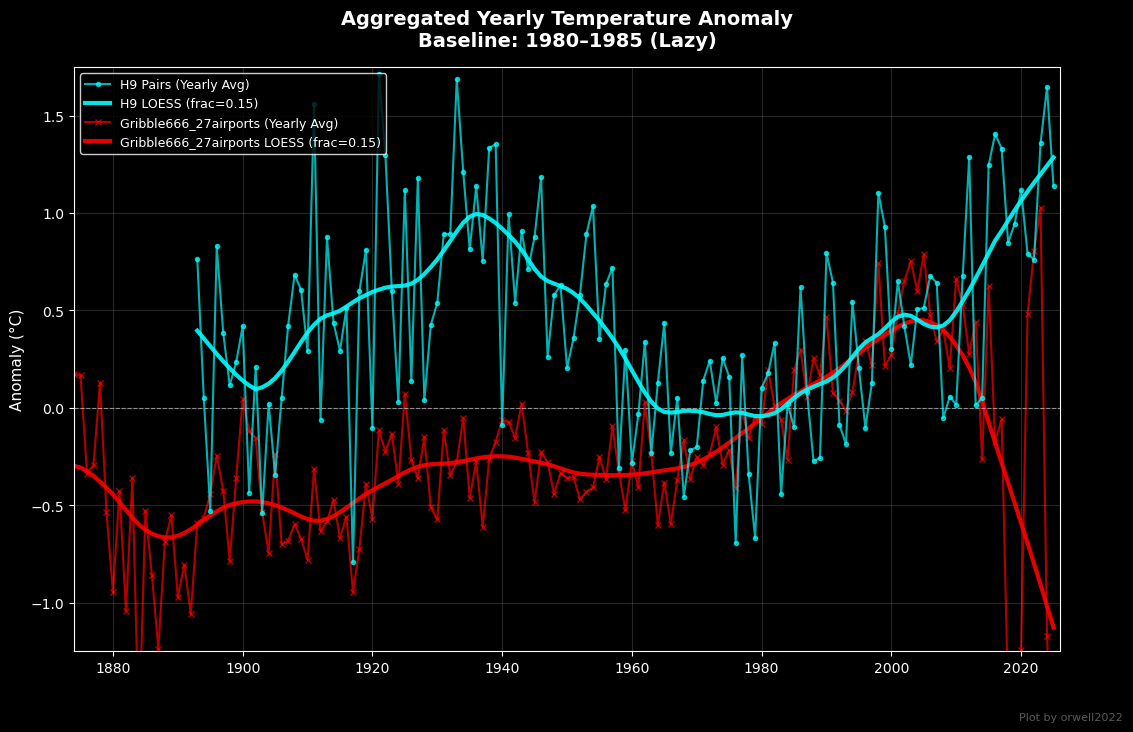

In [91]:
# FINAL PLOT v17: Yearly Aggregated Anomalies (H9 vs Gribble), Specific Settings

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # For LOESS smoothing
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import sys
import io
import requests
import tarfile

warnings.filterwarnings("ignore") # Suppress all warnings for simplicity

# ==============================================================================
# Configuration -- USER MODIFIED SETTINGS
# ==============================================================================

# --- Baseline Period & Filter ---
BASELINE_START_YEAR = 1980# USER SET
BASELINE_END_YEAR = 1985   # USER SET
# Lazy baseline - calculate using any available data within this period
print(f"Baseline Period (Lazy): {BASELINE_START_YEAR}-{BASELINE_END_YEAR}")

# --- Data Time Range & Plot Limits ---
# Load data potentially before plot start for context
DATA_LOAD_START_YEAR = 1850 # Start loading data earlier just in case
# Plotting range
PLOT_START_YEAR = 1875 # USER SET
PLOT_END_YEAR = 2025   # USER SET
# Analysis implicitly runs up to plot end year for included data
END_YEAR_FOR_ANALYSIS = PLOT_END_YEAR

# --- Smoothing for Yearly Plot ---
yearly_smoothing_frac = 0.15 # Adjust as needed

# --- Plotting Limits ---
Y_LIMITS = (-1.25, 1.75) # USER SET

# --- Station Groups ---
STATION_PAIRS_H9 = [
    ("USC00012813", "USW00063869"), ("USC00294426", "USW00003074"),
    ("USC00402202", "USW00063855"), ("USC00250030", "USW00094077"),
    ("USC00018385", "USW00073801"), ("USC00380764", "USW00063826"),
    ("USC00013160", "USW00063892"), ("USC00348501", "USW00053926"),
    ("USC00082850", "USW00092826")
]
STATION_IDS_GRIBBLE = {
    "USC00412266", "SG000061612", "FP000091958", "SU000062600", "CI000085406",
    "FSM00061996", "ASN00038003", "AYM00088968", "FGXLT442638", "USW00024022",
    "RSM00032071", "SHM00068906", "TZ000063832", "USC00082915", "AYM00089063",
    "NZ000939870", "SHM00061901", "GLE00100981", "ZA000067743", "SXM00088903",
    "SZ000061717", "USC00509015", "AYM00089642", "RSM00030879", "USC00300085",
    "BR026393280", "NZ000093994"
}
gribble_series_name = "Gribble666_27airports"
component_station_ids = {sid for pair in STATION_PAIRS_H9 for sid in pair}
all_needed_ids = component_station_ids.union(STATION_IDS_GRIBBLE)
print(f"Processing {len(STATION_PAIRS_H9)} H9 pairs and {len(STATION_IDS_GRIBBLE)} Gribble stations.")

# --- Data Source ---
GHCN_DATA_URL = "https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcu.tar.gz"

# --- Attribution ---
PLOT_ATTRIBUTION = "Plot by orwell2022" # USER SET

# ==============================================================================
# Step 0: Download and Parse Data
# ==============================================================================
print("\n--- Step 0: Downloading and Parsing ---")
# ... (Standard robust data loading, respecting DATA_LOAD_START_YEAR) ...
filtered_lines = []; dat_member_name = "Unknown"
try:
    response = requests.get(GHCN_DATA_URL, stream=True); response.raise_for_status(); tar_bytes = io.BytesIO(response.content)
    with tarfile.open(fileobj=tar_bytes, mode="r:gz") as tar:
        dat_member = [m for m in tar.getmembers() if m.name.endswith(".qcu.dat")][0]; print(f"Extracting {dat_member.name}")
        with tar.extractfile(dat_member) as dat_file:
            for line_bytes in dat_file:
                try: line_str = line_bytes.decode("utf-8"); sid = line_str[0:11]
                except Exception : continue
                if sid in all_needed_ids and line_str[15:19] == "TAVG": filtered_lines.append(line_str)
except Exception as e: print(f"Tar Error: {e}"); sys.exit()
monthly_records = []; parse_errors = 0; print("Parsing data...")
for line in filtered_lines:
    sid = line[0:11].strip();
    try:
        year = int(line[11:15])
        # Filter years during parsing to reduce memory slightly
        if year < DATA_LOAD_START_YEAR or year > END_YEAR_FOR_ANALYSIS: continue
        for m in range(12):
            month = m + 1; start_idx = 19 + m*8; end_idx = start_idx + 5; val_str = line[start_idx : end_idx].strip()
            if val_str and val_str != "-9999": monthly_records.append([year, month, sid, int(val_str) / 100.0])
    except Exception as e: parse_errors += 1
df_monthly_raw = pd.DataFrame(monthly_records, columns=["year", "month", "station_id", "tavg"])
print(f"Parsed {len(df_monthly_raw)} TAVG records for {df_monthly_raw['station_id'].nunique()} target stations between {DATA_LOAD_START_YEAR}-{END_YEAR_FOR_ANALYSIS}.")
if parse_errors > 0: print(f"Encountered {parse_errors} parsing errors.")
if df_monthly_raw.empty: print("FATAL ERROR: No records parsed."); sys.exit()

# ==============================================================================
# Step 1: Stitch H9 Pairs (Simple Avg/Select)
# ==============================================================================
print("\n--- Step 1: Stitching Pairs ---")
# ... (Same simple stitching logic as v11) ...
processed_stitched_data = []; defined_composite_ids = []
for pair in STATION_PAIRS_H9:
    legacy_id, uscrn_id = pair; pair_id_str = f"COMP_{legacy_id}_{uscrn_id}"; defined_composite_ids.append(pair_id_str)
    df_legacy = df_monthly_raw[df_monthly_raw['station_id'] == legacy_id][['year', 'month', 'tavg']].copy()
    df_uscrn = df_monthly_raw[df_monthly_raw['station_id'] == uscrn_id][['year', 'month', 'tavg']].copy()
    if not df_legacy.set_index(['year', 'month']).index.is_unique: df_legacy = df_legacy.groupby(['year', 'month'], as_index=False)['tavg'].mean()
    if not df_uscrn.set_index(['year', 'month']).index.is_unique: df_uscrn = df_uscrn.groupby(['year', 'month'], as_index=False)['tavg'].mean()
    merged = pd.merge(df_legacy, df_uscrn, on=['year', 'month'], how='outer', suffixes=('_legacy', '_uscrn'))
    merged['tavg'] = np.where(merged['tavg_uscrn'].notna() & merged['tavg_legacy'].notna(), (merged['tavg_legacy'] + merged['tavg_uscrn']) / 2.0, merged['tavg_uscrn'].combine_first(merged['tavg_legacy']))
    stitched_result = merged[['year', 'month', 'tavg']].copy(); stitched_result.dropna(subset=['tavg'], inplace=True)
    if not stitched_result.empty: stitched_result['station_id'] = pair_id_str; processed_stitched_data.append(stitched_result)
    else: processed_stitched_data.append(pd.DataFrame({'year': [], 'month': [], 'station_id': [pair_id_str], 'tavg': []}))
df_h9_stitched = pd.concat(processed_stitched_data, ignore_index=True)
print(f"Completed stitching. {df_h9_stitched['station_id'].nunique()} pairs have some data.")

# ==============================================================================
# Step 2: Prepare Data for Anomaly Calculation
# ==============================================================================
df_gribble_solo = df_monthly_raw[df_monthly_raw['station_id'].isin(STATION_IDS_GRIBBLE)][['year', 'month', 'station_id', 'tavg']].copy()
df_all_processed = pd.concat([df_h9_stitched, df_gribble_solo], ignore_index=True)
# No further time filtering needed here as parsing already handled END_YEAR_FOR_ANALYSIS

# ==============================================================================
# Step 3: Calculate "Lazy" Baselines (USER DEFINED)
# ==============================================================================
print(f"\n--- Step 3: Calculating Lazy Baselines ({BASELINE_START_YEAR}-{BASELINE_END_YEAR}) ---")
baseline_period_data = df_all_processed[(df_all_processed['year'] >= BASELINE_START_YEAR) & (df_all_processed['year'] <= BASELINE_END_YEAR)].copy()
if baseline_period_data.empty: print(f"ERROR: No data in baseline period {BASELINE_START_YEAR}-{BASELINE_END_YEAR}. Cannot calculate baselines."); sys.exit()
monthly_baselines = baseline_period_data.groupby(['station_id', 'month'])['tavg'].mean().reset_index().rename(columns={'tavg': 'baseline_mean'})
print(f"Calculated baseline means for {monthly_baselines['station_id'].nunique()} stations.")

# ==============================================================================
# Step 4: Calculate Monthly Anomalies
# ==============================================================================
print("\n--- Step 4: Calculating Monthly Anomalies ---")
df_anomalies_all = pd.merge(df_all_processed, monthly_baselines, on=['station_id', 'month'], how='left')
df_anomalies_all['anomaly'] = df_anomalies_all['tavg'] - df_anomalies_all['baseline_mean']
df_anomalies_all.dropna(subset=['anomaly'], inplace=True) # Keep only valid anomalies
print(f"Calculated {len(df_anomalies_all)} non-NaN monthly anomalies across all stations.")

# ==============================================================================
# Step 5: Aggregate Yearly Anomalies per Group
# ==============================================================================
print("\n--- Step 5: Aggregating Yearly Anomalies ---")
h9_composite_ids = [sid for sid in defined_composite_ids if sid in df_anomalies_all['station_id'].unique()]
df_anomalies_h9 = df_anomalies_all[df_anomalies_all['station_id'].isin(h9_composite_ids)]
df_anomalies_gribble = df_anomalies_all[df_anomalies_all['station_id'].isin(STATION_IDS_GRIBBLE)]
# Aggregate H9
df_agg_h9_yearly = pd.DataFrame()
if not df_anomalies_h9.empty:
    monthly_agg_h9 = df_anomalies_h9.groupby(['year', 'month'])['anomaly'].mean().reset_index()
    df_agg_h9_yearly = monthly_agg_h9.groupby('year')['anomaly'].mean().reset_index().dropna()
    print(f"H9: Calculated aggregated yearly anomaly for {len(df_agg_h9_yearly)} years.")
else: print("H9: No anomalies available for aggregation.")
# Aggregate Gribble
df_agg_gribble_yearly = pd.DataFrame()
if not df_anomalies_gribble.empty:
    monthly_agg_gribble = df_anomalies_gribble.groupby(['year', 'month'])['anomaly'].mean().reset_index()
    df_agg_gribble_yearly = monthly_agg_gribble.groupby('year')['anomaly'].mean().reset_index().dropna()
    print(f"Gribble: Calculated aggregated yearly anomaly for {len(df_agg_gribble_yearly)} years.")
else: print("Gribble: No anomalies available for aggregation.")

# ==============================================================================
# Step 6: Plotting Yearly Aggregated Anomalies with Specific Settings
# ==============================================================================
print("\n--- Step 6: Plotting Yearly Aggregated Anomalies ---")

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 8)) # Standard figure size

plot_title = f"Aggregated Yearly Temperature Anomaly\nBaseline: {BASELINE_START_YEAR}–{BASELINE_END_YEAR} (Lazy)"
ax.set_title(plot_title, fontsize=14, weight='bold', color='white', pad=15)

# Plot H9 Yearly Anomaly
h9_yearly_plotted = False
if not df_agg_h9_yearly.empty:
    ax.plot(df_agg_h9_yearly["year"], df_agg_h9_yearly["anomaly"], label="H9 Pairs (Yearly Avg)", color='cyan', linewidth=1.5, marker='o', markersize=3, alpha=0.7, zorder=3)
    try: # H9 LOESS
        if len(df_agg_h9_yearly) > 5:
            loess_h9 = sm.nonparametric.lowess(endog=df_agg_h9_yearly["anomaly"], exog=df_agg_h9_yearly["year"], frac=yearly_smoothing_frac)
            ax.plot(loess_h9[:, 0], loess_h9[:, 1], color='cyan', linewidth=3, alpha=0.9, label=f"H9 LOESS (frac={yearly_smoothing_frac})", zorder=4)
            h9_yearly_plotted = True
    except Exception as e: print(f"Could not plot H9 yearly LOESS: {e}")
else: ax.text(0.5, 0.6, "No H9 Yearly Anomaly Data", **{'ha':'center', 'va':'center', 'color':'cyan', 'transform':ax.transAxes})

# Plot Gribble List Yearly Anomaly
gribble_yearly_plotted = False
if not df_agg_gribble_yearly.empty:
    ax.plot(df_agg_gribble_yearly["year"], df_agg_gribble_yearly["anomaly"], label=f"{gribble_series_name} (Yearly Avg)", color='red', linewidth=1.5, marker='x', markersize=4, alpha=0.7, zorder=1)
    try: # Gribble List LOESS
        if len(df_agg_gribble_yearly) > 5:
            loess_gribble = sm.nonparametric.lowess(endog=df_agg_gribble_yearly["anomaly"], exog=df_agg_gribble_yearly["year"], frac=yearly_smoothing_frac)
            ax.plot(loess_gribble[:, 0], loess_gribble[:, 1], color='red', linewidth=3, alpha=0.9, label=f"{gribble_series_name} LOESS (frac={yearly_smoothing_frac})", zorder=2)
            gribble_yearly_plotted = True
    except Exception as e: print(f"Could not plot {gribble_series_name} yearly LOESS: {e}")
else: ax.text(0.5, 0.4, f"No {gribble_series_name} Yearly Anomaly Data", **{'ha':'center', 'va':'center', 'color':'red', 'transform':ax.transAxes})

# --- Formatting ---
ax.set_ylabel("Anomaly (°C)", fontsize=11, color='white'); ax.grid(True, alpha=0.3, color='gray'); ax.axhline(0, color='white', linestyle='--', linewidth=0.8, alpha=0.5)
ax.tick_params(axis='y', colors='white', labelsize=10); ax.tick_params(axis='x', colors='white', labelsize=10)
ax.legend(loc='upper left', fontsize=9, facecolor='black', edgecolor='white')

# *** SET X and Y LIMITS ***
ax.set_xlim(PLOT_START_YEAR - 1, PLOT_END_YEAR + 1)
ax.set_ylim(Y_LIMITS[0], Y_LIMITS[1])

# *** ADD ATTRIBUTION ***
fig.text(0.99, 0.01, PLOT_ATTRIBUTION, ha='right', va='bottom', fontsize=8, color='gray', alpha=0.7)

# Adjust layout
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.92])

# --- Save Plot ---
try:
    output_filename = f"ghcnv4m_YearlyAnom_H9vsGribble_LazyBl_{BASELINE_START_YEAR}-{BASELINE_END_YEAR}_PlotRange_{PLOT_START_YEAR}-{PLOT_END_YEAR}.png"
    plt.savefig(output_filename, dpi=150, bbox_inches='tight', facecolor='black')
    print(f"\nYearly anomaly plot saved as {output_filename}")
except Exception as e: print(f"\nError saving plot: {e}")

print("\n--- Plotting Yearly Aggregated Anomalies Complete ---")

Anomaly Baseline Period: 1970-1980
Using stations that passed filter: >= 9 months/year for 1965-2024

--- Step 0: Downloading and Parsing ---
Extracting ./ghcnm.v4.0.1.20250415/ghcnm.tavg.v4.0.1.20250415.qcu.dat
Parsing data...
Parsed 44437 TAVG records.

--- Step 1: Stitching Pairs ---
Completed stitching. 9 pairs have some data.

--- Step 2: Identifying Stations Passing Filter (9 months/yr, 1965-2024) ---
Filter Results: 10 stations PASS.

--- Step 3: Selecting Data from Passing Stations ---
Selected data for 4 passing H9 pairs.
Selected data for 6 passing Gribble stations.

--- Step 4: Calculating Lazy Baselines (1970-1980) for Passing Stations ---
Calculated baseline means for 10 passing stations.

--- Step 5: Calculating Monthly Anomalies ---
Calculated 13912 non-NaN monthly anomalies for passing stations.

--- Step 6: Aggregating Yearly Anomalies ---
H9: Aggregated yearly anomaly for 133 years (from 4 passing pairs).
Gribble: Aggregated yearly anomaly for 176 years (from 6 passin

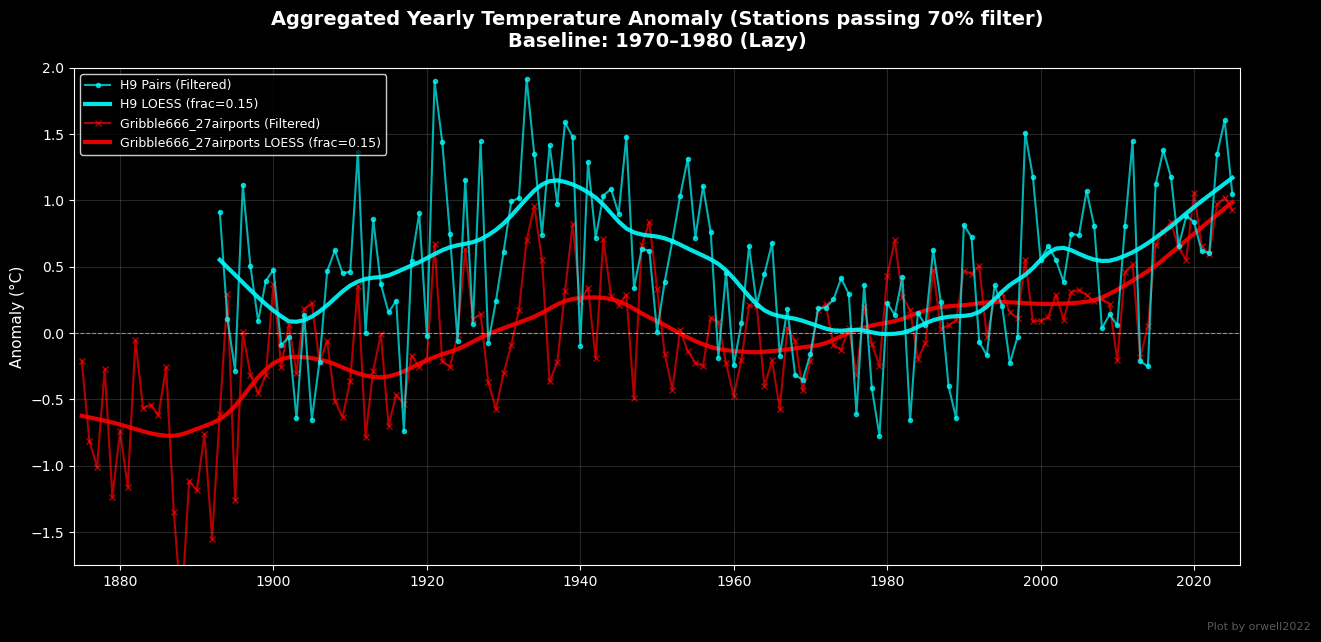

In [92]:
# FINAL PLOT v19: Yearly Aggregated Anomalies of FILTERED Stations

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # For LOESS smoothing
import matplotlib.dates as mdates
import sys
import io
import requests
import tarfile
import math # For ceil

warnings.filterwarnings("ignore") # Suppress all warnings

# ==============================================================================
# Configuration -- USER MODIFIED SETTINGS from previous steps
# ==============================================================================

# --- Baseline Period for Anomaly Calculation ---
BASELINE_START_YEAR = 1970 # USER SET
BASELINE_END_YEAR = 1980   # USER SET
print(f"Anomaly Baseline Period: {BASELINE_START_YEAR}-{BASELINE_END_YEAR}")

# --- Filtering Period & Criteria (Applied *before* this script) ---
# These define which stations are *eligible* based on the prior check
FILTER_START_YEAR = 1965
FILTER_END_YEAR = 2024
PERCENT_MONTHS_REQUIRED = 70
MIN_MONTHS_PER_YEAR = math.ceil(PERCENT_MONTHS_REQUIRED / 100.0 * 12)
print(f"Using stations that passed filter: >= {MIN_MONTHS_PER_YEAR} months/year for {FILTER_START_YEAR}-{FILTER_END_YEAR}")

# --- Data Time Range & Plot Limits ---
DATA_LOAD_START_YEAR = 1850
END_YEAR_FOR_ANALYSIS = 2025 # Match previous plot range
PLOT_START_YEAR = 1875 # USER SET
PLOT_END_YEAR = 2025   # USER SET
Y_LIMITS = (-1.75, 2) # USER SET

# --- Smoothing for Yearly Plot ---
yearly_smoothing_frac = 0.15

# --- Station Groups ---
STATION_PAIRS_H9 = [
    ("USC00012813", "USW00063869"), ("USC00294426", "USW00003074"),
    ("USC00402202", "USW00063855"), ("USC00250030", "USW00094077"),
    ("USC00018385", "USW00073801"), ("USC00380764", "USW00063826"),
    ("USC00013160", "USW00063892"), ("USC00348501", "USW00053926"),
    ("USC00082850", "USW00092826")
]
STATION_IDS_GRIBBLE = {
    "USC00412266", "SG000061612", "FP000091958", "SU000062600", "CI000085406",
    "FSM00061996", "ASN00038003", "AYM00088968", "FGXLT442638", "USW00024022",
    "RSM00032071", "SHM00068906", "TZ000063832", "USC00082915", "AYM00089063",
    "NZ000939870", "SHM00061901", "GLE00100981", "ZA000067743", "SXM00088903",
    "SZ000061717", "USC00509015", "AYM00089642", "RSM00030879", "USC00300085",
    "BR026393280", "NZ000093994"
}
gribble_series_name = "Gribble666_27airports"
component_station_ids = {sid for pair in STATION_PAIRS_H9 for sid in pair}
all_needed_ids = component_station_ids.union(STATION_IDS_GRIBBLE)
defined_composite_ids = [f"COMP_{p[0]}_{p[1]}" for p in STATION_PAIRS_H9] # Define all 9 names

# --- Data Source ---
GHCN_DATA_URL = "https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcu.tar.gz"
# --- Attribution ---
PLOT_ATTRIBUTION = "Plot by orwell2022"

# ==============================================================================
# Step 0: Download and Parse Data
# ==============================================================================
print("\n--- Step 0: Downloading and Parsing ---")
# ... (Standard robust data loading) ...
filtered_lines = []; dat_member_name = "Unknown"
try:
    response = requests.get(GHCN_DATA_URL, stream=True); response.raise_for_status(); tar_bytes = io.BytesIO(response.content)
    with tarfile.open(fileobj=tar_bytes, mode="r:gz") as tar:
        dat_member = [m for m in tar.getmembers() if m.name.endswith(".qcu.dat")][0]; print(f"Extracting {dat_member.name}")
        with tar.extractfile(dat_member) as dat_file:
            for line_bytes in dat_file:
                try: line_str = line_bytes.decode("utf-8"); sid = line_str[0:11]
                except Exception : continue
                if sid in all_needed_ids and line_str[15:19] == "TAVG": filtered_lines.append(line_str)
except Exception as e: print(f"Tar Error: {e}"); sys.exit()
monthly_records = []; parse_errors = 0; print("Parsing data...")
for line in filtered_lines:
    sid = line[0:11].strip();
    try:
        year = int(line[11:15])
        if year < DATA_LOAD_START_YEAR or year > END_YEAR_FOR_ANALYSIS: continue
        for m in range(12):
            month = m + 1; start_idx = 19 + m*8; end_idx = start_idx + 5; val_str = line[start_idx : end_idx].strip()
            if val_str and val_str != "-9999": monthly_records.append([year, month, sid, int(val_str) / 100.0])
    except Exception as e: parse_errors += 1
df_monthly_raw = pd.DataFrame(monthly_records, columns=["year", "month", "station_id", "tavg"])
print(f"Parsed {len(df_monthly_raw)} TAVG records.")
if parse_errors > 0: print(f"Encountered {parse_errors} parsing errors.")
if df_monthly_raw.empty: print("FATAL ERROR: No records parsed."); sys.exit()

# ==============================================================================
# Step 1: Stitch H9 Pairs (Simple Avg/Select)
# ==============================================================================
print("\n--- Step 1: Stitching Pairs ---")
# ... (Same simple stitching logic as v11) ...
processed_stitched_data = []
composite_ids_with_data = [] # Only IDs that produced data
for pair in STATION_PAIRS_H9:
    legacy_id, uscrn_id = pair; pair_id_str = f"COMP_{legacy_id}_{uscrn_id}"
    df_legacy = df_monthly_raw[df_monthly_raw['station_id'] == legacy_id][['year', 'month', 'tavg']].copy()
    df_uscrn = df_monthly_raw[df_monthly_raw['station_id'] == uscrn_id][['year', 'month', 'tavg']].copy()
    if not df_legacy.set_index(['year', 'month']).index.is_unique: df_legacy = df_legacy.groupby(['year', 'month'], as_index=False)['tavg'].mean()
    if not df_uscrn.set_index(['year', 'month']).index.is_unique: df_uscrn = df_uscrn.groupby(['year', 'month'], as_index=False)['tavg'].mean()
    merged = pd.merge(df_legacy, df_uscrn, on=['year', 'month'], how='outer', suffixes=('_legacy', '_uscrn'))
    merged['tavg'] = np.where(merged['tavg_uscrn'].notna() & merged['tavg_legacy'].notna(), (merged['tavg_legacy'] + merged['tavg_uscrn']) / 2.0, merged['tavg_uscrn'].combine_first(merged['tavg_legacy']))
    stitched_result = merged[['year', 'month', 'tavg']].copy(); stitched_result.dropna(subset=['tavg'], inplace=True)
    if not stitched_result.empty: stitched_result['station_id'] = pair_id_str; processed_stitched_data.append(stitched_result); composite_ids_with_data.append(pair_id_str)
if processed_stitched_data: df_h9_stitched = pd.concat(processed_stitched_data, ignore_index=True); print(f"Completed stitching. {len(composite_ids_with_data)} pairs have some data.")
else: df_h9_stitched = pd.DataFrame(columns=['year','month','station_id','tavg']); print("Warning: No H9 pairs resulted in stitched data.")

# ==============================================================================
# Step 2: Identify Passing Stations (Re-run filter logic)
# ==============================================================================
print(f"\n--- Step 2: Identifying Stations Passing Filter ({MIN_MONTHS_PER_YEAR} months/yr, {FILTER_START_YEAR}-{FILTER_END_YEAR}) ---")
df_gribble_solo = df_monthly_raw[df_monthly_raw['station_id'].isin(STATION_IDS_GRIBBLE)][['year', 'month', 'station_id', 'tavg']].copy()
df_for_filter_check = pd.concat([df_h9_stitched, df_gribble_solo], ignore_index=True)
df_filter_period = df_for_filter_check[
    (df_for_filter_check['year'] >= FILTER_START_YEAR) &
    (df_for_filter_check['year'] <= FILTER_END_YEAR)
].copy()

stations_passing_filter = []
if not df_filter_period.empty:
    monthly_counts = df_filter_period.groupby(['station_id', 'year'])['month'].nunique().unstack(fill_value=0)
    required_years = list(range(FILTER_START_YEAR, FILTER_END_YEAR + 1))
    monthly_counts = monthly_counts.reindex(columns=required_years, fill_value=0)
    passes_filter = (monthly_counts >= MIN_MONTHS_PER_YEAR).all(axis=1)
    stations_passing_filter = passes_filter[passes_filter].index.tolist()
    print(f"Filter Results: {len(stations_passing_filter)} stations PASS.")
    if len(stations_passing_filter) == 0:
        print("WARNING: No stations passed the filter. Anomaly plot will likely be empty.")
    # else:
        # print("Passing Stations:", stations_passing_filter) # Optional: print list
else:
    print(f"No data found in the filter period {FILTER_START_YEAR}-{FILTER_END_YEAR}. Cannot apply filter.")
    stations_passing_filter = [] # Ensure it's empty

# ==============================================================================
# Step 3: Prepare Data for Anomaly Calculation (Using ONLY Passing Stations)
# ==============================================================================
print("\n--- Step 3: Selecting Data from Passing Stations ---")
passing_h9_ids = [sid for sid in composite_ids_with_data if sid in stations_passing_filter]
passing_gribble_ids = [sid for sid in STATION_IDS_GRIBBLE if sid in stations_passing_filter]

df_h9_filtered = df_h9_stitched[df_h9_stitched['station_id'].isin(passing_h9_ids)].copy()
df_gribble_filtered = df_gribble_solo[df_gribble_solo['station_id'].isin(passing_gribble_ids)].copy()

print(f"Selected data for {len(passing_h9_ids)} passing H9 pairs.")
print(f"Selected data for {len(passing_gribble_ids)} passing Gribble stations.")

df_all_filtered = pd.concat([df_h9_filtered, df_gribble_filtered], ignore_index=True)

# ==============================================================================
# Step 4: Calculate "Lazy" Baselines for Passing Stations
# ==============================================================================
print(f"\n--- Step 4: Calculating Lazy Baselines ({BASELINE_START_YEAR}-{BASELINE_END_YEAR}) for Passing Stations ---")
monthly_baselines = pd.DataFrame() # Initialize empty
if not df_all_filtered.empty:
    baseline_period_data = df_all_filtered[
        (df_all_filtered['year'] >= BASELINE_START_YEAR) &
        (df_all_filtered['year'] <= BASELINE_END_YEAR)
    ].copy()
    if not baseline_period_data.empty:
        monthly_baselines = baseline_period_data.groupby(['station_id', 'month'])['tavg'].mean().reset_index()
        monthly_baselines.rename(columns={'tavg': 'baseline_mean'}, inplace=True)
        print(f"Calculated baseline means for {monthly_baselines['station_id'].nunique()} passing stations.")
    else: print(f"No data found in baseline period {BASELINE_START_YEAR}-{BASELINE_END_YEAR} for passing stations.")
else: print("No data from passing stations to calculate baselines from.")

# ==============================================================================
# Step 5: Calculate Monthly Anomalies for Passing Stations
# ==============================================================================
print("\n--- Step 5: Calculating Monthly Anomalies ---")
df_anomalies_filtered = pd.DataFrame() # Initialize empty
if not monthly_baselines.empty and not df_all_filtered.empty:
    df_anomalies_filtered = pd.merge(
        df_all_filtered, monthly_baselines, on=['station_id', 'month'], how='left'
    )
    df_anomalies_filtered['anomaly'] = df_anomalies_filtered['tavg'] - df_anomalies_filtered['baseline_mean']
    df_anomalies_filtered.dropna(subset=['anomaly'], inplace=True)
    print(f"Calculated {len(df_anomalies_filtered)} non-NaN monthly anomalies for passing stations.")
else: print("Skipping anomaly calculation as no valid baselines or filtered data exist.")

# ==============================================================================
# Step 6: Aggregate Yearly Anomalies per Group (using passing stations)
# ==============================================================================
print("\n--- Step 6: Aggregating Yearly Anomalies ---")
df_agg_h9_yearly = pd.DataFrame()
df_agg_gribble_yearly = pd.DataFrame()

if not df_anomalies_filtered.empty:
    # Separate H9 and Gribble anomalies from the filtered set
    df_anomalies_h9_final = df_anomalies_filtered[df_anomalies_filtered['station_id'].isin(passing_h9_ids)]
    df_anomalies_gribble_final = df_anomalies_filtered[df_anomalies_filtered['station_id'].isin(passing_gribble_ids)]

    # Aggregate H9
    if not df_anomalies_h9_final.empty:
        monthly_agg_h9 = df_anomalies_h9_final.groupby(['year', 'month'])['anomaly'].mean().reset_index()
        df_agg_h9_yearly = monthly_agg_h9.groupby('year')['anomaly'].mean().reset_index().dropna()
        print(f"H9: Aggregated yearly anomaly for {len(df_agg_h9_yearly)} years (from {len(passing_h9_ids)} passing pairs).")
    else: print("H9: No anomalies from passing pairs available for aggregation.")

    # Aggregate Gribble
    if not df_anomalies_gribble_final.empty:
        monthly_agg_gribble = df_anomalies_gribble_final.groupby(['year', 'month'])['anomaly'].mean().reset_index()
        df_agg_gribble_yearly = monthly_agg_gribble.groupby('year')['anomaly'].mean().reset_index().dropna()
        print(f"Gribble: Aggregated yearly anomaly for {len(df_agg_gribble_yearly)} years (from {len(passing_gribble_ids)} passing stations).")
    else: print("Gribble: No anomalies from passing stations available for aggregation.")
else: print("No anomalies calculated, skipping aggregation.")

# ==============================================================================
# Step 7: Plotting Yearly Aggregated Anomalies with Specific Settings
# ==============================================================================
print("\n--- Step 7: Plotting Yearly Aggregated Anomalies ---")
plt.style.use('dark_background'); fig, ax = plt.subplots(figsize=(14, 7))
plot_title = f"Aggregated Yearly Temperature Anomaly (Stations passing {PERCENT_MONTHS_REQUIRED}% filter)\nBaseline: {BASELINE_START_YEAR}–{BASELINE_END_YEAR} (Lazy)"
ax.set_title(plot_title, fontsize=14, weight='bold', color='white', pad=15)

# Plot H9 Yearly Anomaly
h9_yearly_plotted = False
if not df_agg_h9_yearly.empty:
    # Plot only within the requested PLOT range
    df_plot_h9 = df_agg_h9_yearly[(df_agg_h9_yearly['year']>=PLOT_START_YEAR) & (df_agg_h9_yearly['year']<=PLOT_END_YEAR)]
    if not df_plot_h9.empty:
        ax.plot(df_plot_h9["year"], df_plot_h9["anomaly"], label="H9 Pairs (Filtered)", color='cyan', linewidth=1.5, marker='o', markersize=3, alpha=0.7, zorder=3)
        try: # H9 LOESS
            if len(df_plot_h9) > 5: loess_h9 = sm.nonparametric.lowess(endog=df_plot_h9["anomaly"], exog=df_plot_h9["year"], frac=yearly_smoothing_frac); ax.plot(loess_h9[:, 0], loess_h9[:, 1], color='cyan', linewidth=3, alpha=0.9, label=f"H9 LOESS (frac={yearly_smoothing_frac})", zorder=4); h9_yearly_plotted = True
            else: h9_yearly_plotted = True # Mark as plotted even without LOESS if points exist
        except Exception as e: print(f"Could not plot H9 yearly LOESS: {e}")
else: ax.text(0.5, 0.6, "No H9 Yearly Anomaly Data (Post-Filter)", **{'ha':'center', 'va':'center', 'color':'cyan', 'transform':ax.transAxes})

# Plot Gribble List Yearly Anomaly
gribble_yearly_plotted = False
if not df_agg_gribble_yearly.empty:
    df_plot_gribble = df_agg_gribble_yearly[(df_agg_gribble_yearly['year']>=PLOT_START_YEAR) & (df_agg_gribble_yearly['year']<=PLOT_END_YEAR)]
    if not df_plot_gribble.empty:
        ax.plot(df_plot_gribble["year"], df_plot_gribble["anomaly"], label=f"{gribble_series_name} (Filtered)", color='red', linewidth=1.5, marker='x', markersize=4, alpha=0.7, zorder=1)
        try: # Gribble List LOESS
            if len(df_plot_gribble) > 5: loess_gribble = sm.nonparametric.lowess(endog=df_plot_gribble["anomaly"], exog=df_plot_gribble["year"], frac=yearly_smoothing_frac); ax.plot(loess_gribble[:, 0], loess_gribble[:, 1], color='red', linewidth=3, alpha=0.9, label=f"{gribble_series_name} LOESS (frac={yearly_smoothing_frac})", zorder=2); gribble_yearly_plotted = True
            else: gribble_yearly_plotted = True # Mark as plotted even without LOESS
        except Exception as e: print(f"Could not plot {gribble_series_name} yearly LOESS: {e}")
else: ax.text(0.5, 0.4, f"No {gribble_series_name} Yearly Anomaly Data (Post-Filter)", **{'ha':'center', 'va':'center', 'color':'red', 'transform':ax.transAxes})

# Formatting
ax.set_ylabel("Anomaly (°C)", fontsize=11, color='white'); ax.grid(True, alpha=0.3, color='gray'); ax.axhline(0, color='white', linestyle='--', linewidth=0.8, alpha=0.5)
ax.tick_params(axis='y', colors='white', labelsize=10); ax.tick_params(axis='x', colors='white', labelsize=10)
ax.legend(loc='upper left', fontsize=9, facecolor='black', edgecolor='white')
# SET X and Y LIMITS
ax.set_xlim(PLOT_START_YEAR - 1, PLOT_END_YEAR + 1); ax.set_ylim(Y_LIMITS[0], Y_LIMITS[1])
# ADD ATTRIBUTION
fig.text(0.99, 0.01, PLOT_ATTRIBUTION, ha='right', va='bottom', fontsize=8, color='gray', alpha=0.7)
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.92])
# --- Save Plot ---
try:
    output_filename = f"ghcnv4m_YearlyAnom_H9vsGribble_FILTERED_{FILTER_START_YEAR}-{FILTER_END_YEAR}_Bl_{BASELINE_START_YEAR}-{BASELINE_END_YEAR}_Plot_{PLOT_START_YEAR}-{PLOT_END_YEAR}.png"
    plt.savefig(output_filename, dpi=150, bbox_inches='tight', facecolor='black')
    print(f"\nYearly anomaly plot saved as {output_filename}")
except Exception as e: print(f"\nError saving plot: {e}")
print("\n--- Plotting Yearly Aggregated Anomalies of Filtered Stations Complete ---")

In [93]:
import requests
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import io

# === Settings ===
meta_csv_path = Path("/Users/administrator/ghcnv4_meta_matched_by_rural_be_kdtree_11km.csv")
start_year = 1925
end_year = 2024
n_months = (end_year - start_year + 1) * 12
tarball_name = "ghcnm.tavg.latest.qcu.tar.gz"
local_tarball = Path(tarball_name)
output_image = Path("ghcn_coverage_bitmap_sorted.png")

# === Step 1: Load matched stations from metadata
print("Loading station metadata...")
meta_df = pd.read_csv(meta_csv_path)
station_ids = set(meta_df['ID'].astype(str).str.strip())
station_list = sorted(list(station_ids))
station_index = {sid: i for i, sid in enumerate(station_list)}
n_stations = len(station_list)

# === Step 2: Download tarball if not present
if not local_tarball.exists():
    print(f"Downloading GHCN QCU archive to {tarball_name}...")
    url = "https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcu.tar.gz"
    r = requests.get(url, stream=True)
    with open(local_tarball, 'wb') as f:
        f.write(r.content)
else:
    print(f"Using cached file: {tarball_name}")

# === Step 3: Extract only matching TAVG lines
print("Extracting and filtering .dat lines...")
filtered_lines = []
with tarfile.open(local_tarball, "r:gz") as tar:
    dat_member = next(m for m in tar.getmembers() if m.name.endswith(".qcu.dat"))
    dat_file = tar.extractfile(dat_member)
    for line in dat_file:
        sid = line[0:11].decode("utf-8").strip()
        if sid in station_ids and line[15:19].decode("utf-8") == "TAVG":
            filtered_lines.append(line.decode("utf-8"))

# === Step 4: Build binary presence matrix
print("Populating binary data matrix...")
binary_matrix = np.zeros((n_stations, n_months), dtype=np.uint8)

for line in filtered_lines:
    sid = line[0:11].strip()
    year = int(line[11:15])
    if not (start_year <= year <= end_year):
        continue
    row = station_index[sid]
    values = [int(line[19 + m * 8:24 + m * 8]) for m in range(12)]
    for i, val in enumerate(values):
        col = (year - start_year) * 12 + i
        if val != -9999:
            binary_matrix[row, col] = 1

# === Step 5: Filter zero-data stations, then sort
station_sums = binary_matrix.sum(axis=1)
valid_rows = station_sums > 0
binary_matrix = binary_matrix[valid_rows]
station_array = np.array(station_list)[valid_rows]
station_sums = station_sums[valid_rows]

sort_order = np.argsort(station_sums)
binary_matrix_sorted = binary_matrix[sort_order]
station_list_sorted = station_array[sort_order]

# === Step 5b: Filter entire stations with ≥10 months/year for ALL years
print("Filtering to stations with all 100 years having ≥10 valid months...")
min_months_per_year=9
n_years = end_year - start_year + 1
reshaped = binary_matrix.reshape(-1, n_years, 12)
valid_years = np.sum(reshaped, axis=2) >= min_months_per_year
stations_pass = np.all(valid_years, axis=1)

binary_matrix_strict10 = binary_matrix[stations_pass]
station_array_strict10 = station_array[stations_pass]

us_count = np.sum([sid.startswith("US") for sid in station_array_strict10])
non_us_count = len(station_array_strict10) - us_count


# === Step 6: Latitude sort prep
meta_df['ID'] = meta_df['ID'].astype(str).str.strip()
lat_lookup = meta_df.set_index('ID')['Lat'].to_dict()
valid_latitudes = np.array([lat_lookup[sid] for sid in station_array])
lat_sort_order = np.argsort(-valid_latitudes)
binary_matrix_lat_sorted = binary_matrix[lat_sort_order]
station_list_lat_sorted = station_array[lat_sort_order]
latitudes_sorted = valid_latitudes[lat_sort_order]
y_labels_lat = [f"{station_list_lat_sorted[i]} ({latitudes_sorted[i]:.1f}°)" for i in range(len(station_list_lat_sorted))]

# === Step 6b: Basemap of strict-10-month stations (27 total)
print("Generating basemap of 100% complete stations (1925–2024)...")

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Get lat/lon for remaining stations
strict_meta = meta_df.set_index('ID').loc[station_array_strict10]

fig, ax = plt.subplots(figsize=(12, 6))
m = Basemap(projection='robin', lon_0=0, resolution='l', ax=ax)
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.3)
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')

x, y = m(strict_meta['Lon'].values, strict_meta['Lat'].values)
m.scatter(x, y, marker='o', color='red', s=50, edgecolors='k', zorder=5)

ax.set_title(f"GHCNv4 Stations with Full Data (≥{min_months_per_year} Months/Year for Every Year 1925–2024)", fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("ghcn_strict_month_basemap.png", dpi=200)
plt.close()
print("✅ Saved: ghcn_strict10month_basemap.png")

# === Plotting function using GridSpec for footer stability
def plot_bitmap(rgb_data, station_ids, title, ylabel, output_path, footer_text, y_tick_labels=None):
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1], hspace=0.2)

    ax = fig.add_subplot(gs[0])
    ax.imshow(rgb_data, aspect='auto')
    ax.set_title(title, fontsize=20, weight='bold', pad=20)
    ax.set_xlabel("Months (1925–2024)", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    month_ticks = np.linspace(0, n_months - 1, 11, dtype=int)
    month_labels = [str(start_year + i * 10) for i in range(11)]
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(month_labels, rotation=45)

    n_rows = rgb_data.shape[0]
    if n_rows > 40:
        y_ticks = np.arange(0, n_rows, 500)
        y_labels = [y_tick_labels[i] if y_tick_labels else station_ids[i] for i in y_ticks]
    else:
        y_ticks = np.arange(n_rows)
        y_labels = y_tick_labels if y_tick_labels else station_ids
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=8)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=8)

    ax_footer = fig.add_subplot(gs[1])
    ax_footer.axis('off')
    ax_footer.text(
        0, 1.0, footer_text,
        fontsize=9, color='black', va='top', ha='left', wrap=True,
        transform=ax_footer.transAxes, linespacing=1.4
    )

    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"✅ Saved: {output_path.resolve()}")

# === Footer (shared)
footer_text = (
    "Data: NOAA GHCN v4 QCU (unadjusted) monthly temps (1925–2024)\n"
    "Stations: Matched to Wickham et al. (2013) 'very rural' list via BE_site_detail_Connolly2014_McIntyre2011.txt\n"
    "Audit: Reanalysis using modern urbanization datasets (GHSL P2023A) • Visualization by orwell2022\n"
    "Reference: Wickham et al. (2013), JGR Atmospheres, https://doi.org/10.1002/jgrd.50202 • https://github.com/orwell2024/GHCN-tools"
)

# === Plot 1: sorted by total months of data
rgb = np.zeros((binary_matrix_sorted.shape[0], n_months, 3), dtype=np.uint8)
rgb[:, :, :] = [255, 0, 0]
rgb[binary_matrix_sorted == 1] = [0, 255, 0]
plot_bitmap(
    rgb_data=rgb,
    station_ids=station_list_sorted,
    title="Monthly Data Coverage for Matched GHCNv4 Stations (1925–2024)\nSorted by Total Data Coverage",
    ylabel=f"Stations (sorted by total data months) — Total: {binary_matrix_sorted.shape[0]}",
    output_path=output_image,
    footer_text=footer_text
)

# === Plot 2: sorted by latitude
rgb_lat = np.zeros((binary_matrix_lat_sorted.shape[0], n_months, 3), dtype=np.uint8)
rgb_lat[:, :, :] = [255, 0, 0]
rgb_lat[binary_matrix_lat_sorted == 1] = [0, 255, 0]
plot_bitmap(
    rgb_data=rgb_lat,
    station_ids=station_list_lat_sorted,
    title="Monthly Data Coverage for Matched GHCNv4 Stations (1925–2024)\nSorted by Latitude (North → South)",
    ylabel=f"Stations (sorted by latitude) — Total: {binary_matrix_lat_sorted.shape[0]}",
    output_path=Path("ghcn_coverage_bitmap_sorted_by_latitude.png"),
    footer_text=footer_text,
    y_tick_labels=y_labels_lat
)
# === Plot 3: Only years with >=10 months of data
rgb_10m = np.zeros((binary_matrix_strict10.shape[0], n_months, 3), dtype=np.uint8)
rgb_10m[:, :, :] = [255, 0, 0]
rgb_10m[binary_matrix_strict10 == 1] = [0, 255, 0]

plot_bitmap(
    rgb_data=rgb_10m,
    station_ids=station_array_strict10,
    title=f"Stations With All Years ≥10 Months (1925–2024)\nUS: {us_count} • Non-US: {non_us_count}",
    ylabel=f"Strict 10-month/year filter — Total: {binary_matrix_strict10.shape[0]}",
    output_path=Path("ghcn_coverage_bitmap_strict10months.png"),
    footer_text=footer_text
)


Loading station metadata...
Using cached file: ghcnm.tavg.latest.qcu.tar.gz
Extracting and filtering .dat lines...
Populating binary data matrix...
Filtering to stations with all 100 years having ≥10 valid months...
Generating basemap of 100% complete stations (1925–2024)...
✅ Saved: ghcn_strict10month_basemap.png
✅ Saved: C:\Users\Administrator\ghcn_coverage_bitmap_sorted.png
✅ Saved: C:\Users\Administrator\ghcn_coverage_bitmap_sorted_by_latitude.png
✅ Saved: C:\Users\Administrator\ghcn_coverage_bitmap_strict10months.png


In [ ]:
import requests
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import io
from PIL import Image
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec

# === Config ===
meta_csv_path = Path("/Users/administrator/ghcnv4_meta_matched_by_rural_be_kdtree_11km.csv")
start_year = 1925
end_year = 2024
n_months = (end_year - start_year + 1) * 12
baseline_start = 1930
baseline_end = 1945
min_months_per_year = 9

# === Step 1: Load metadata
meta_df = pd.read_csv(meta_csv_path)
meta_df['ID'] = meta_df['ID'].astype(str).str.strip()
station_ids = set(meta_df['ID'])
station_list = sorted(station_ids)
station_index = {sid: i for i, sid in enumerate(station_list)}

# === Step 2: Download GHCN QCU
tarball_name = "ghcnm.tavg.latest.qcu.tar.gz"
local_tarball = Path(tarball_name)
if not local_tarball.exists():
    url = "https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcu.tar.gz"
    r = requests.get(url, stream=True)
    with open(local_tarball, 'wb') as f:
        f.write(r.content)

# === Step 3: Extract relevant TAVG lines
filtered_lines = []
with tarfile.open(local_tarball, "r:gz") as tar:
    dat_member = next(m for m in tar.getmembers() if m.name.endswith(".qcu.dat"))
    dat_file = tar.extractfile(dat_member)
    for line in dat_file:
        sid = line[0:11].decode("utf-8").strip()
        if sid in station_ids and line[15:19].decode("utf-8") == "TAVG":
            filtered_lines.append(line.decode("utf-8"))

# === Step 4: Binary matrix
n_stations = len(station_list)
binary_matrix = np.zeros((n_stations, n_months), dtype=np.uint8)

for line in filtered_lines:
    sid = line[0:11].strip()
    if sid not in station_index:
        continue
    year = int(line[11:15])
    if not (start_year <= year <= end_year):
        continue
    row = station_index[sid]
    values = [int(line[19 + m * 8:24 + m * 8]) for m in range(12)]
    for i, val in enumerate(values):
        col = (year - start_year) * 12 + i
        if val != -9999:
            binary_matrix[row, col] = 1

# === Step 5: Keep stations where all years >= min_months_per_year
n_years = end_year - start_year + 1
reshaped = binary_matrix.reshape(-1, n_years, 12)
valid_years = np.sum(reshaped, axis=2) >= min_months_per_year
stations_pass = np.all(valid_years, axis=1)

binary_matrix_strict = binary_matrix[stations_pass]
station_array_strict = np.array(station_list)[stations_pass]

# === Step 6: Raw PNG output
rgb_raw = np.zeros((binary_matrix_strict.shape[0], n_months, 3), dtype=np.uint8)
rgb_raw[:, :, :] = [255, 0, 0]
rgb_raw[binary_matrix_strict == 1] = [0, 255, 0]
Image.fromarray(rgb_raw).save(f"ghcn_strict{min_months_per_year}month_raw.png")

# === Step 7: Labeled bitmap plot
def plot_bitmap(rgb_data, station_ids, title, ylabel, output_path, footer_text):
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 1, height_ratios=[14, 1], hspace=0.2)
    ax = fig.add_subplot(gs[0])
    ax.imshow(rgb_data, aspect='auto')
    ax.set_title(title, fontsize=18, weight='bold', pad=20)
    ax.set_xlabel("Months (1925–2024)", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    month_ticks = np.linspace(0, n_months - 1, 11, dtype=int)
    month_labels = [str(start_year + i * 10) for i in range(11)]
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(month_labels, rotation=45)
    n_rows = rgb_data.shape[0]
    y_ticks = np.arange(0, n_rows, max(n_rows // 20, 1))
    y_labels = station_ids[y_ticks] if len(station_ids) > 1 else station_ids
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=7 if len(y_labels) > 40 else 9)
    ax_footer = fig.add_subplot(gs[1])
    ax_footer.axis('off')
    ax_footer.text(0, 1.0, footer_text, fontsize=9, color='black', va='top', ha='left', wrap=True, transform=ax_footer.transAxes, linespacing=1.3)
    plt.savefig(output_path, dpi=300)
    plt.close()

footer_text = (
    f"Data: GHCN v4 QCU (unadjusted), 1925–2024\n"
    f"Stations with ≥{min_months_per_year} valid months/year, full record\n"
    f"Filtered: excludes BU>3% (2020) in 2km+10km or >100% BU growth in any radius"
)

plot_bitmap(
    rgb_data=rgb_raw,
    station_ids=station_array_strict,
    title=f"Stations With All Years ≥{min_months_per_year} Months (1925–2024)",
    ylabel=f"Strict {min_months_per_year}-month/year filter — Total: {binary_matrix_strict.shape[0]}",
    output_path=Path(f"ghcn_strict{min_months_per_year}month_bitmap.png"),
    footer_text=footer_text
)

# === Step 8: Basemap
strict_meta = meta_df.set_index('ID').loc[station_array_strict]
fig, ax = plt.subplots(figsize=(12, 6))
m = Basemap(projection='robin', lon_0=0, resolution='l', ax=ax)
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.3)
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')
x, y = m(strict_meta['Lon'].values, strict_meta['Lat'].values)
m.scatter(x, y, marker='o', color='red', s=50, edgecolors='k', zorder=5)
ax.set_title(f"GHCNv4 Stations with Full Data (≥{min_months_per_year} Months/Year, 1925–2024)", fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig(f"ghcn_strict{min_months_per_year}month_basemap.png", dpi=200)
plt.close()

# === Step 9: Temperature table with BU filtering
data_by_station = {}
for line in filtered_lines:
    sid = line[0:11].strip()
    if sid not in station_array_strict:
        continue
    year = int(line[11:15])
    if not (start_year <= year <= end_year):
        continue
    values = [int(line[19 + m * 8:24 + m * 8]) for m in range(12)]
    monthly = [v / 100.0 if v != -9999 else np.nan for v in values]
    if sid not in data_by_station:
        data_by_station[sid] = {}
    data_by_station[sid][year] = monthly

# === Step 10: Anomaly time series vs VALENTIA with LOESS and enhanced footnotes
from statsmodels.nonparametric.smoothers_lowess import lowess

# === Apply metadata filters ===
valid_ids_bu = set(meta_df[
    (meta_df['Built_2020_2km_percent'] <= 3.0) &
    (meta_df['Built_2020_10km_percent'] <= 3.0) &
    (meta_df['Percentage_Change_2km'] <= 100.0) &
    (meta_df['Percentage_Change_10km'] <= 100.0) &
    (meta_df['Percentage_Change_50km'] <= 100.0) &
   (meta_df['Lat'] <= 90.0)             
]['ID'].astype(str))

station_array_strict_filtered = [sid for sid in station_array_strict if sid in valid_ids_bu]

monthly_data = []
for line in filtered_lines:
    sid = line[0:11].strip()
    if sid not in station_array_strict and sid not in station_array_strict_filtered:
        continue
    year = int(line[11:15])
    if not (start_year <= year <= end_year):
        continue
    values = [int(line[19 + m * 8:24 + m * 8]) for m in range(12)]
    monthly = [v / 100.0 if v != -9999 else np.nan for v in values]
    for month_idx, val in enumerate(monthly):
        monthly_data.append((sid, year, month_idx + 1, val))

monthly_df = pd.DataFrame(monthly_data, columns=["station_id", "year", "month", "tavg"])
baselines = (
    monthly_df[(monthly_df["year"] >= baseline_start) & (monthly_df["year"] <= baseline_end)]
    .groupby(["station_id", "month"])["tavg"]
    .mean()
    .rename("baseline")
    .reset_index()
)
monthly_anom = pd.merge(monthly_df, baselines, on=["station_id", "month"], how="left")
monthly_anom["anomaly"] = monthly_anom["tavg"] - monthly_anom["baseline"]
yearly_anom = (
    monthly_anom.dropna(subset=["anomaly"])
    .groupby(["station_id", "year"])["anomaly"]
    .mean()
    .reset_index()
)

ensemble_full = yearly_anom[yearly_anom["station_id"].isin(station_array_strict)]
ensemble_filt = yearly_anom[yearly_anom["station_id"].isin(station_array_strict_filtered)]

mean_full = ensemble_full.groupby("year")["anomaly"].mean().reset_index()
mean_full["label"] = "Filtered Ensemble"
mean_filt = ensemble_filt.groupby("year")["anomaly"].mean().reset_index()
mean_filt["label"] = "Meta-Filtered Subset"

valentia_id = meta_df[meta_df["Station"] == "VALENTIA_OBSERVATORY"]["ID"].values
if len(valentia_id) > 0:
    valentia_id = valentia_id[0]
    valentia_data = yearly_anom[yearly_anom["station_id"] == valentia_id].copy()
    valentia_data["label"] = "VALENTIA_OBSERVATORY"
    plot_df = pd.concat([mean_full, mean_filt, valentia_data], ignore_index=True)
else:
    plot_df = pd.concat([mean_full, mean_filt], ignore_index=True)

# === Plot with LOESS
plt.figure(figsize=(14, 7))
colors = {
    "Filtered Ensemble": "red",
    "Meta-Filtered Subset": "green",
    "VALENTIA_OBSERVATORY": "blue"
}

for label, group in plot_df.groupby("label"):
    plt.plot(group["year"], group["anomaly"], label=label, color=colors[label], linewidth=1.5, alpha=0.4)
    smoothed = lowess(group["anomaly"], group["year"], frac=0.2, return_sorted=True)
    plt.plot(smoothed[:, 0], smoothed[:, 1], color=colors[label], linewidth=3, alpha=0.8)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Yearly Temperature Anomalies with LOESS\nFiltered GHCNv4 Ensemble vs VALENTIA_OBSERVATORY\nMatched to Wickham et al. (2013) / Berkeley Earth Rural Subset", fontsize=13, weight='bold')
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.legend()
plt.grid(True, alpha=0.3)

footer_lines = [
    f"Baseline: {baseline_start}–{baseline_end} monthly mean per station. @orwell2022, GHCNv4 Ensemble vs VALENTIA_OBSERVATORY\nMatched to Wickham et al. (2013) / Berkeley Earth Rural Subset.",
    f"After data continuity filter min per year month: {min_months_per_year}month: {', '.join(station_array_strict)}",
    f"After GHSL P2013A Built 1975-2020 filter BU 2020 ≤3% (2km+10km), ΔBU ≤100% (2km, 10km, 50km) and lat <60 : {', '.join(station_array_strict_filtered)}",
    f"VALENTIA (blue): {valentia_id if valentia_id else 'N/A'}"
]
footer_text = "\n".join(footer_lines)

plt.figtext(0.01, -0.01, footer_lines[0], ha='left', fontsize=8, wrap=True, color='black')
plt.figtext(0.01, -0.085, footer_lines[1], ha='left', fontsize=8, wrap=True, color='red')
plt.figtext(0.01, -0.125, footer_lines[2], ha='left', fontsize=8, wrap=True, color='green')
plt.figtext(0.01, -0.15, footer_lines[3], ha='left', fontsize=8, wrap=True, color='blue', weight='bold')
plt.tight_layout()
plt.savefig(f"ghcn_anomaly_timeseries_strict{min_months_per_year}month.png", dpi=300, bbox_inches='tight')
plt.close()
print(f"✅ Saved: ghcn_anomaly_timeseries_strict{min_months_per_year}month.png")

# === Generate 3-panel Basemap
fig, axes = plt.subplots(1, 3, figsize=(18, 3))
titles = [
    f"All Stations ≥{min_months_per_year} Months/Year",
    "Subset Passing Metadata BU Filter",
    "VALENTIA_OBSERVATORY Reference"
]
colors = ["red", "green", "blue"]
station_groups = [
    station_array_strict,
    station_array_strict_filtered,
    [valentia_id] if len(valentia_id) > 0 else []
]

for ax, title, color, station_ids in zip(axes, titles, colors, station_groups):
    m = Basemap(projection='robin', lon_0=0, resolution='l', ax=ax)
    m.drawcoastlines(linewidth=0.3)
    m.drawcountries(linewidth=0.2)
    m.drawmapboundary(fill_color='lightblue')
    m.fillcontinents(color='lightgray', lake_color='lightblue')

    coords = meta_df.set_index("ID").loc[station_ids][["Lon", "Lat"]].dropna()
    x, y = m(coords["Lon"].values, coords["Lat"].values)
    m.scatter(x, y, marker='o', color=color, s=30, edgecolors='k', zorder=5)
    ax.set_title(title, fontsize=10, weight='bold')

# === Footer
footer_text = (
    "All: {total} | BU-passing: {filtered} | Wickham et al. (2013) Rural Subset, "
    "Filters: ≥{months} months/year from 1925–2024, BU 2020 ≤3% (2km+10km), ΔBU ≤100% (2km, 10km, 50km)\n"
    "Data: NOAA GHCN v4 QCU: https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcu.tar.gz\n"
    "Station List: https://github.com/orwell2024/GHCN-tools/blob/main/Wickham2013_forensicauditby_GHSLP2023A/BE_site_detail_Connolly2014_McIntyre2011.txt\n"
    "Plot by orwell2022"
).format(
    total=len(station_array_strict),
    filtered=len(station_array_strict_filtered),
    months=min_months_per_year
)

plt.figtext(0.01, -0.15, footer_text, ha='left', fontsize=9, wrap=True)
plt.tight_layout()
plt.savefig(f"ghcn_strict{min_months_per_year}month_basemap_tripanel.png", dpi=300, bbox_inches='tight')
plt.close()
print(f"✅ Saved: ghcn_strict{min_months_per_year}month_basemap_tripanel.png")

# === Time Series: Individual Station Curves by Category
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

station_sets = {
    'All Stations': (station_array_strict, 'red'),
    'BU-Filtered Subset': (station_array_strict_filtered, 'green'),
    'VALENTIA_OBSERVATORY': ([valentia_id], 'blue') if len(valentia_id) > 0 else ([], 'blue')
}

plt.figure(figsize=(14, 7))
plt.subplots_adjust(bottom=0.3)
for label, (stations, color) in station_sets.items():
    for sid in stations:
        series = yearly_anom[yearly_anom["station_id"] == sid]
        if not series.empty:
            smoothed = lowess(series["anomaly"], series["year"], frac=0.0, return_sorted=True)
            linewidth_val = 5 if label == 'VALENTIA_OBSERVATORY' else 1
            plt.plot(smoothed[:, 0], smoothed[:, 1], color=color, alpha=0.6, linewidth=linewidth_val)

# Legend entries
for label, (_, color) in station_sets.items():
    plt.plot([], [], color=color, label=label, linewidth=2.5)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Station-Level Anomaly by Filter Category\nWickham et al. (2013) Rural Subset", fontsize=13, weight='bold')
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.legend()
plt.grid(True, alpha=0.3)

# === Footer
footer_ids = (
    "IDs (All/red): " + ", ".join(station_array_strict) + "\n"
    + "IDs (BU-filtered/green): " + ", ".join(station_array_strict_filtered) + "\n"
    + f"VALENTIA (blue): {valentia_id if valentia_id else 'N/A'}"
)
plt.figtext(0.01, -0.1, footer_ids, ha='left', fontsize=5, wrap=True)
plt.tight_layout()
plt.savefig(f"ghcn_timeseries_LOESS_by_station_strict{min_months_per_year}month.png", dpi=300)
plt.close()
print(f"✅ Saved: ghcn_timeseries_LOESS_by_station_strict{min_months_per_year}month.png")

✅ Saved: ghcn_anomaly_timeseries_strict9month.png
✅ Saved: ghcn_strict9month_basemap_tripanel.png
